In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier, LGBMRegressor
import optuna
from sklearn.model_selection import train_test_split

from library.Data_Preprocessing import Balance_Ratio, train_col
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### lightgbm

In [2]:
def LightGBMC(train_x, test_x, train_y, test_y, config):
    
    clf = LGBMClassifier(**config)
    clf.fit(train_x, train_y)
    predict_y = clf.predict_proba(test_x)[:, 1]
    define_predict = (predict_y > 0.5).astype(int)
    result = pd.DataFrame({'truth': test_y, 'predict': define_predict})
    
    return result


def LightGBMR(train_x, test_x, train_y, test_y, config):
    
    reg = LGBMRegressor(**config)
    reg.fit(train_x, train_y)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


def runall_LightGBMC(num_set, trainset_x, test_x, trainset_y, test_y, config):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config
        
        result = LightGBMC(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        table = cf_matrix(result, trainset_y[f'set{i}'])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})
        
    return table_set
    
    
def runall_LightGBMR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = LightGBMR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})

    return pr_dict, table_set

### optuna

In [3]:
def LightGBM_creator(train_data, mode, num_valid = 3, label = 'GB') :

    def objective(trial) :
    
        param = {
            'objective': trial.suggest_categorical('objective', ['binary', 'cross_entropy']),
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss']),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300, step = 50),
            'subsample': trial.suggest_float('subsample', 0.5, 0.9, step = 0.2),
            'num_leaves': trial.suggest_int('num_leaves', 5, 40, step = 5),
            'min_child_samples': trial.suggest_int('min_child_samples', 3, 24, step = 3),
            'max_depth': trial.suggest_int('max_depth', 3, 15, step = 2),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.425, step = 0.05),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 5), # alpha
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 5) # lambda
        }

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)

            if mode == 'C':
                result = LightGBMC(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                precision = table['Precision']
                beta = 0.75
                fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision)
                result_list.append(fscore)

            elif mode == 'R':
                result = LightGBMR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)

    return objective

## 

### loading training & testing data

In [4]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (1404, 88)  balance ratio: 1.0
Dimension of dataset 2 : (1928, 88)  balance ratio: 1.0
Dimension of dataset 3 : (1514, 88)  balance ratio: 1.0
Dimension of dataset 4 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 5 : (1370, 88)  balance ratio: 1.01
Dimension of dataset 6 : (1662, 88)  balance ratio: 0.71
Dimension of dataset 7 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 8 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (2304, 97)  balance ratio: 1.0
Dimension of dataset 2 : (3150, 97)  balance ratio: 1.0
Dimension of dataset 3 : (2480, 97)  balance ratio: 1.0
Dimension of dataset 4 : (2258, 97)  balance ratio: 1.0
Dimension of dataset 5 : (2271, 97)  balance ratio: 0.99
Dimensio

### search for best hyperparameter

In [5]:
best_paramC, all_scoreC = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = True, 
                                     n_iter = 200,
                                     filename = 'runhist_array_m2m4_m5_3criteria_LightGBM',
                                     creator = LightGBM_creator
                                    )

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 00:55:35,167] A new study created in memory with name: no-name-5e915b14-a9bc-4ace-9bdc-951ac6d96476


Dataset0 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.7843137254901961 
Recall: 0.5263157894736842 
Aging Rate: 0.0012981393336218088
Precision: 0.7843137254901961 
Recall: 0.5263157894736842 
Aging Rate: 0.0012981393336218088
Precision: 0.8837209302325582 
Recall: 0.5 
Aging Rate: 0.0010945096342301526
[I 2021-12-13 00:55:40,181] Trial 0 finished with value: 0.6752510528020732 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.14114425386268484, 'reg_lambda': 0.03433117996925238}. Best is trial 0 with value: 0.6752510528020732.
Precision: 0.18518518518518517 
Recall: 0.06578947368421052 
Aging Rate: 0.0006872502354468399
Precision: 0.008928571428571428 
Recall: 0.013157894736842105 
Aging Rate: 0.0028508157914831876
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0012981393336218088
[W 2021-12-13 00:55:45,109] Trial 1 failed, because the objective function retu

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 00:56:43,556] Trial 13 failed, because the objective function returned nan.
Precision: 0.057971014492753624 
Recall: 0.05263157894736842 
Aging Rate: 0.0017563061572530353
Precision: 0.16083916083916083 
Recall: 0.3026315789473684 
Aging Rate: 0.003639880876625856
Precision: 0.02631578947368421 
Recall: 0.013157894736842105 
Aging Rate: 0.0009672410721103674
[I 2021-12-13 00:56:50,613] Trial 14 finished with value: 0.08958355532881139 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.001221452336180633, 'reg_lambda': 0.032439850193885254}. Best is trial 6 with value: 0.832881986896895.
Precision: 0.17857142857142858 
Recall: 0.06578947368421052 
Aging Rate: 0.0007127039478707969
Precision: 0.2 
Recall: 0.039473684210526314 
Aging Rate: 0.0003818056863593555
Pr

Precision: 0.9824561403508771 
Recall: 0.7368421052631579 
Aging Rate: 0.001450861608165551
Precision: 0.7704918032786885 
Recall: 0.618421052631579 
Aging Rate: 0.001552676457861379
Precision: 0.9411764705882353 
Recall: 0.631578947368421 
Aging Rate: 0.0012981393336218088
[I 2021-12-13 00:57:46,625] Trial 26 finished with value: 0.7950081025857817 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.05461295426244643, 'reg_lambda': 0.7741892631246042}. Best is trial 20 with value: 0.8872578669138004.
Precision: 0.873015873015873 
Recall: 0.7236842105263158 
Aging Rate: 0.0016035838827092933
Precision: 0.953125 
Recall: 0.8026315789473685 
Aging Rate: 0.0016290375951332503
Precision: 0.8888888888888888 
Recall: 0.7368421052631579 
Aging Rate: 0.0016035838827092933
[I 2021-12-13 00:57:51,518] Trial 27 finished with value: 0.844309354947652

Precision: 0.12 
Recall: 0.19736842105263158 
Aging Rate: 0.003181714052994629
[I 2021-12-13 00:58:45,616] Trial 38 finished with value: 0.09096534521138828 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.007813763228089644, 'reg_lambda': 0.03534055112585019}. Best is trial 28 with value: 0.8936349531178317.
Precision: 0.9354838709677419 
Recall: 0.7631578947368421 
Aging Rate: 0.001578130170285336
Precision: 0.9242424242424242 
Recall: 0.8026315789473685 
Aging Rate: 0.0016799450199811643
Precision: 0.9285714285714286 
Recall: 0.6842105263157895 
Aging Rate: 0.0014254078957415938
[I 2021-12-13 00:58:51,526] Trial 39 finished with value: 0.8547922410002314 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 11, 'learning_rate': 0

Precision: 0.5299145299145299 
Recall: 0.8157894736842105 
Aging Rate: 0.002978084353602973
Precision: 0.4636363636363636 
Recall: 0.6710526315789473 
Aging Rate: 0.0027999083666352736
Precision: 0.5 
Recall: 0.75 
Aging Rate: 0.002901723216331102
[I 2021-12-13 00:59:52,961] Trial 51 finished with value: 0.5654279515532138 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.007593825660076334, 'reg_lambda': 0.06222026454624478}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.847457627118644 
Recall: 0.6578947368421053 
Aging Rate: 0.001501769033013465
Precision: 0.921875 
Recall: 0.7763157894736842 
Aging Rate: 0.0016290375951332503
Precision: 0.9027777777777778 
Recall: 0.8552631578947368 
Aging Rate: 0.0018326672945249065
[I 2021-12-13 00:59:57,812] Trial 52 finished with value: 0.8388242195699606 and paramet

Precision: 0.927536231884058 
Recall: 0.8421052631578947 
Aging Rate: 0.0017563061572530353
[I 2021-12-13 01:00:54,397] Trial 63 finished with value: 0.8808306573550041 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.000183823190658142, 'reg_lambda': 3.0264601560201925}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.8688524590163934 
Recall: 0.6973684210526315 
Aging Rate: 0.001552676457861379
Precision: 0.8923076923076924 
Recall: 0.7631578947368421 
Aging Rate: 0.0016544913075572073
Precision: 0.953125 
Recall: 0.8026315789473685 
Aging Rate: 0.0016290375951332503
[I 2021-12-13 01:01:00,500] Trial 64 finished with value: 0.8440390664414369 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate':

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 01:01:14,972] Trial 67 failed, because the objective function returned nan.
Precision: 0.821917808219178 
Recall: 0.7894736842105263 
Aging Rate: 0.0018581210069488635
Precision: 0.8108108108108109 
Recall: 0.7894736842105263 
Aging Rate: 0.0018835747193728205
Precision: 0.9473684210526315 
Recall: 0.7105263157894737 
Aging Rate: 0.001450861608165551
[I 2021-12-13 01:01:20,620] Trial 68 finished with value: 0.8195992418366993 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.0008482437113102744, 'reg_lambda': 0.36643360522317836}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.921875 
Recall: 0.7763157894736842 
Aging Rate: 0.0016290375951332503
Precision: 0.9193548387096774 
Recall: 0.75 
Aging Rate: 0.001578130170285336
Precision: 0.8412698412698413 
Recall: 0.6973

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 01:01:35,692] Trial 71 failed, because the objective function returned nan.
Precision: 0.98 
Recall: 0.6447368421052632 
Aging Rate: 0.0012726856211978518
Precision: 0.9347826086956522 
Recall: 0.5657894736842105 
Aging Rate: 0.0011708707715020236
Precision: 0.9298245614035088 
Recall: 0.6973684210526315 
Aging Rate: 0.001450861608165551
[I 2021-12-13 01:01:41,789] Trial 72 finished with value: 0.804238150962489 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.000674572533011197, 'reg_lambda': 4.937272526883491}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.9629629629629629 
Recall: 0.6842105263157895 
Aging Rate: 0.0013745004708936798
Precision: 0.9411764705882353 
Recall: 0.631578947368421 
Aging Rate: 0.0012981393336218088
Precision: 0.9019607843137255 
Recall: 

Precision: 0.8285714285714286 
Recall: 0.7631578947368421 
Aging Rate: 0.0017817598696769925
Precision: 0.8133333333333334 
Recall: 0.8026315789473685 
Aging Rate: 0.0019090284317967775
Precision: 0.8266666666666667 
Recall: 0.8157894736842105 
Aging Rate: 0.0019090284317967775
[I 2021-12-13 01:02:51,101] Trial 84 finished with value: 0.8119783354753062 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.0001432517117198492, 'reg_lambda': 0.5265487489661694}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.9666666666666667 
Recall: 0.7631578947368421 
Aging Rate: 0.001527222745437422
Precision: 0.88 
Recall: 0.5789473684210527 
Aging Rate: 0.0012726856211978518
Precision: 0.9811320754716981 
Recall: 0.6842105263157895 
Aging Rate: 0.0013490467584697228
[I 2021-12-13 01:02:56,571] Trial 85 finished with value: 0.82393299822388

Precision: 0.9215686274509803 
Recall: 0.618421052631579 
Aging Rate: 0.0012981393336218088
[I 2021-12-13 01:03:48,226] Trial 96 finished with value: 0.8439196405553714 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.0001784777159458616, 'reg_lambda': 0.2891901197592821}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.85 
Recall: 0.6710526315789473 
Aging Rate: 0.001527222745437422
Precision: 0.8695652173913043 
Recall: 0.7894736842105263 
Aging Rate: 0.0017563061572530353
Precision: 0.9230769230769231 
Recall: 0.7894736842105263 
Aging Rate: 0.0016544913075572073
[I 2021-12-13 01:03:54,799] Trial 97 finished with value: 0.8281810751068548 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.37

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 01:04:22,518] Trial 103 failed, because the objective function returned nan.
Precision: 0.9696969696969697 
Recall: 0.42105263157894735 
Aging Rate: 0.0008399725099905821
Precision: 0.9310344827586207 
Recall: 0.35526315789473684 
Aging Rate: 0.000738157660294754
Precision: 0.8064516129032258 
Recall: 0.32894736842105265 
Aging Rate: 0.000789065085142668
[I 2021-12-13 01:04:26,800] Trial 104 finished with value: 0.5925687058754893 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 3, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.0009308876735942009, 'reg_lambda': 3.2434323322485974}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.8955223880597015 
Recall: 0.7894736842105263 
Aging Rate: 0.0017053987324051213
Precision: 0.9090909090909091 
Recall: 0.6578947368421053 
Aging Rate: 0.0013999541833176368
Precision: 0.870

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 01:05:16,259] Trial 114 failed, because the objective function returned nan.
Precision: 0.9642857142857143 
Recall: 0.7105263157894737 
Aging Rate: 0.0014254078957415938
Precision: 0.90625 
Recall: 0.7631578947368421 
Aging Rate: 0.0016290375951332503
Precision: 0.9384615384615385 
Recall: 0.8026315789473685 
Aging Rate: 0.0016544913075572073
[I 2021-12-13 01:05:21,911] Trial 115 finished with value: 0.8626490937464902 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0029866231745226206, 'reg_lambda': 2.813806106215141}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.7228915662650602 
Recall: 0.7894736842105263 
Aging Rate: 0.0021126581311884337
Precision: 0.8405797101449275 
Recall: 0.7631578947368421 
Aging Rate: 0.0017563061572530353
Precision: 0.8

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 01:05:30,660] Trial 117 failed, because the objective function returned nan.
Precision: 0.0 
Recall: 0.0 
Aging Rate: 5.090742484791407e-05
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0001527222745437422
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
[W 2021-12-13 01:05:34,893] Trial 118 failed, because the objective function returned nan.
Precision: 0.8333333333333334 
Recall: 0.06578947368421052 
Aging Rate: 0.0001527222745437422
Precision: 0.13043478260869565 
Recall: 0.039473684210526314 
Aging Rate: 0.0005854353857510118
Precision: 0.0967741935483871 
Recall: 0.039473684210526314 
Aging Rate: 0.000789065085142668
[I 2021-12-13 01:05:39,081] Trial 119 finished with value: 0.0983695026519026 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 1.6092

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 01:05:58,399] Trial 123 failed, because the objective function returned nan.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 01:06:01,791] Trial 124 failed, because the objective function returned nan.
Precision: 0.8939393939393939 
Recall: 0.7763157894736842 
Aging Rate: 0.0016799450199811643
Precision: 1.0 
Recall: 0.7105263157894737 
Aging Rate: 0.0013745004708936798
Precision: 0.9104477611940298 
Recall: 0.8026315789473685 
Aging Rate: 0.0017053987324051213
[I 2021-12-13 01:06:07,620] Trial 125 finished with value: 0.8627483992460162 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.00047442316064257647, 'reg_lambda': 2.137496611072809}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.9242424242424242 
Recall: 0.8026315789473685 
Aging Rate: 0.0016799450199811643
Precision: 1.0 
Recall: 0.8157894736842105 
Aging Rate: 0.001578130170285336
Precision: 0.9354838709677419 
Recall: 0

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 5.090742484791407e-05
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 2.5453712423957035e-05
[W 2021-12-13 01:07:01,464] Trial 135 failed, because the objective function returned nan.
Precision: 0.9615384615384616 
Recall: 0.32894736842105265 
Aging Rate: 0.0006617965230228829
Precision: 0.972972972972973 
Recall: 0.47368421052631576 
Aging Rate: 0.0009417873596864102
Precision: 0.918918918918919 
Recall: 0.4473684210526316 
Aging Rate: 0.0009417873596864102
[I 2021-12-13 01:07:06,348] Trial 136 finished with value: 0.646551724137931 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.018626799197245254, 'reg_lambda': 1.0086047746541689}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.9272727272727272 
Recall:

Precision: 0.9782608695652174 
Recall: 0.5921052631578947 
Aging Rate: 0.0011708707715020236
Precision: 0.9565217391304348 
Recall: 0.5789473684210527 
Aging Rate: 0.0011708707715020236
Precision: 0.9069767441860465 
Recall: 0.5131578947368421 
Aging Rate: 0.0010945096342301526
[I 2021-12-13 01:08:13,831] Trial 148 finished with value: 0.7591809359558713 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.00011341216630490491, 'reg_lambda': 0.48549902501253905}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.9482758620689655 
Recall: 0.7236842105263158 
Aging Rate: 0.001476315320589508
Precision: 0.8888888888888888 
Recall: 0.7368421052631579 
Aging Rate: 0.0016035838827092933
Precision: 0.9215686274509803 
Recall: 0.618421052631579 
Aging Rate: 0.0012981393336218088
[I 2021-12-13 01:08:20,586] Trial 149 finis

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 01:09:10,224] Trial 158 failed, because the objective function returned nan.
Precision: 0.2 
Recall: 0.02631578947368421 
Aging Rate: 0.00025453712423957034
Precision: 0.21052631578947367 
Recall: 0.05263157894736842 
Aging Rate: 0.0004836205360551837
Precision: 0.25 
Recall: 0.06578947368421052 
Aging Rate: 0.0005090742484791407
[I 2021-12-13 01:09:15,169] Trial 159 finished with value: 0.09498609103059845 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.025, 'reg_alpha': 0.00025144930262210863, 'reg_lambda': 0.012570753193467708}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.8870967741935484 
Recall: 0.7236842105263158 
Aging Rate: 0.001578130170285336
Precision: 0.9365079365079365 
Recall: 0.7763157894736842 
Aging Rate: 0.0016035838827092933
Precision: 0.9393939393939394 
Recall:

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[W 2021-12-13 01:10:14,538] Trial 169 failed, because the objective function returned nan.
Precision: 0.9384615384615385 
Recall: 0.8026315789473685 
Aging Rate: 0.0016544913075572073
Precision: 0.9272727272727272 
Recall: 0.6710526315789473 
Aging Rate: 0.0013999541833176368
Precision: 0.96 
Recall: 0.631578947368421 
Aging Rate: 0.0012726856211978518
[I 2021-12-13 01:10:21,208] Trial 170 finished with value: 0.8361378312976081 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.03479220462864985, 'reg_lambda': 3.6534988160406954}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.8307692307692308 
Recall: 0.7105263157894737 
Aging Rate: 0.0016544913075572073
Precision: 0.9104477611940298 
Recall: 0.8026315789473685 
Aging Rate: 0.0017053987324051213
Precision: 0

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 5.090742484791407e-05
[W 2021-12-13 01:11:09,720] Trial 179 failed, because the objective function returned nan.
Precision: 0.8450704225352113 
Recall: 0.7894736842105263 
Aging Rate: 0.0018072135821009495
Precision: 0.9444444444444444 
Recall: 0.6710526315789473 
Aging Rate: 0.0013745004708936798
Precision: 0.9824561403508771 
Recall: 0.7368421052631579 
Aging Rate: 0.001450861608165551
[I 2021-12-13 01:11:14,368] Trial 180 finished with value: 0.8416707391615592 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.009629168307235751, 'reg_lambda': 0.2228701952252587}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.9516129032258065 
Recall: 0.7763157894736842 
Aging Rate: 0.001578130170285336
Precision: 0.9649122807017

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 5.090742484791407e-05
Precision: 0.6666666666666666 
Recall: 0.02631578947368421 
Aging Rate: 7.63611372718711e-05
[W 2021-12-13 01:12:07,175] Trial 191 failed, because the objective function returned nan.
Precision: 0.10236220472440945 
Recall: 0.17105263157894737 
Aging Rate: 0.0032326214778425435
Precision: 0.08943089430894309 
Recall: 0.14473684210526316 
Aging Rate: 0.003130806628146715
Precision: 0.109375 
Recall: 0.18421052631578946 
Aging Rate: 0.0032580751902665005
[I 2021-12-13 01:12:10,510] Trial 192 finished with value: 0.11715595488137875 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.006835446960044413, 'reg_lambda': 0.04707669343219355}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.9076923076923077 
Reca

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.6666666666666666 
Recall: 0.05263157894736842 
Aging Rate: 0.0001527222745437422
[W 2021-12-13 01:12:24,497] Trial 196 failed, because the objective function returned nan.
Precision: 0.9464285714285714 
Recall: 0.6973684210526315 
Aging Rate: 0.0014254078957415938
Precision: 0.9454545454545454 
Recall: 0.6842105263157895 
Aging Rate: 0.0013999541833176368
Precision: 0.9056603773584906 
Recall: 0.631578947368421 
Aging Rate: 0.0013490467584697228
[I 2021-12-13 01:12:29,683] Trial 197 finished with value: 0.81769981940163 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.09375947334538656, 'reg_lambda': 2.6378755701974095}. Best is trial 41 with value: 0.901620908238459.
Precision: 0.875 
Recall: 0.09210526315789473 
Aging Rate: 0.00020362969939165628
Precision: 1.0 
Recall: 0.039473

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 01:12:41,955] A new study created in memory with name: no-name-2de7576b-acb8-4c48-9328-2fb7a7923564


Precision: 0.9183673469387755 
Recall: 0.5921052631578947 
Aging Rate: 0.0012472319087738946
[I 2021-12-13 01:12:41,809] Trial 199 finished with value: 0.7989781361786449 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0007783323144007189, 'reg_lambda': 2.291797120943939}. Best is trial 41 with value: 0.901620908238459.
Sampler is TPESampler
Dataset1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9883720930232558 
Recall: 0.9973924380704041 
Aging Rate: 0.5045632333767927
Precision: 0.9908854166666666 
Recall: 0.9921773142112125 
Aging Rate: 0.500651890482399
Precision: 0.9883268482490273 
Recall: 0.9934810951760105 
Aging Rate: 0.5026075619295959
[I 2021-12-13 01:12:42,960] Trial 0 finished with value: 0.9910422921929295 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.34702229795375666, 'reg_lambda': 0.0002518627281346852}. Best is trial 0 with value: 0.9910422921929295.
Precision: 0.9921773142112125 
Recall: 0.9921773142112125 
Aging Rate: 0.5
Precision: 0.9896103896103896 
Recall: 0.9934810951760105 
Aging Rate: 0.5019556714471969
Precision: 0.9832689832689833 
Recall: 0.9960886571056062 
Aging Rate: 0.5065189048239895
[I 2021-12-13 01:12:44,028] Trial 1 finished with value: 0.9903411845713003 and param

Precision: 0.9896238651102465 
Recall: 0.9947848761408083 
Aging Rate: 0.5026075619295959
[I 2021-12-13 01:12:53,088] Trial 12 finished with value: 0.9918719551331187 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.42027212883587395, 'reg_lambda': 0.001264424216373311}. Best is trial 12 with value: 0.9918719551331187.
Precision: 0.9934640522875817 
Recall: 0.9908735332464146 
Aging Rate: 0.49869621903520206
Precision: 0.9896103896103896 
Recall: 0.9934810951760105 
Aging Rate: 0.5019556714471969
Precision: 0.9856770833333334 
Recall: 0.9869621903520208 
Aging Rate: 0.500651890482399
[I 2021-12-13 01:12:53,745] Trial 13 finished with value: 0.9898898689291675 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 15, 'l

Precision: 0.9921363040629095 
Recall: 0.9869621903520208 
Aging Rate: 0.4973924380704042
Precision: 0.9922178988326849 
Recall: 0.9973924380704041 
Aging Rate: 0.5026075619295959
Precision: 0.9908735332464146 
Recall: 0.9908735332464146 
Aging Rate: 0.5
[I 2021-12-13 01:13:05,204] Trial 25 finished with value: 0.9917384848734868 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.00027252119782701347, 'reg_lambda': 1.6290964363248666}. Best is trial 19 with value: 0.9932950140955059.
Precision: 0.9844559585492227 
Recall: 0.9908735332464146 
Aging Rate: 0.5032594524119948
Precision: 0.9973684210526316 
Recall: 0.9882659713168188 
Aging Rate: 0.4954367666232073
Precision: 0.9843953185955787 
Recall: 0.9869621903520208 
Aging Rate: 0.5013037809647979
[I 2021-12-13 01:13:06,362] Trial 26 finished with value: 0.9887156086898684 and parameter

Precision: 0.9934640522875817 
Recall: 0.9908735332464146 
Aging Rate: 0.49869621903520206
[I 2021-12-13 01:13:15,632] Trial 37 finished with value: 0.9916634209823817 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.00020661439704856393, 'reg_lambda': 0.015729077854776664}. Best is trial 28 with value: 0.9947838873561325.
Precision: 0.9960629921259843 
Recall: 0.9895697522816167 
Aging Rate: 0.49674054758800523
Precision: 0.9857512953367875 
Recall: 0.9921773142112125 
Aging Rate: 0.5032594524119948
Precision: 0.9908735332464146 
Recall: 0.9908735332464146 
Aging Rate: 0.5
[I 2021-12-13 01:13:16,416] Trial 38 finished with value: 0.9908814054157021 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 1

Precision: 0.9921875 
Recall: 0.9934810951760105 
Aging Rate: 0.500651890482399
Precision: 0.9922077922077922 
Recall: 0.9960886571056062 
Aging Rate: 0.5019556714471969
Precision: 0.9806701030927835 
Recall: 0.9921773142112125 
Aging Rate: 0.5058670143415906
[I 2021-12-13 01:13:25,810] Trial 50 finished with value: 0.9903453473265634 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0011463940546807396, 'reg_lambda': 2.8395232852584327}. Best is trial 28 with value: 0.9947838873561325.
Precision: 0.9882044560943644 
Recall: 0.9830508474576272 
Aging Rate: 0.4973924380704042
Precision: 0.9895968790637191 
Recall: 0.9921773142112125 
Aging Rate: 0.5013037809647979
Precision: 0.9857142857142858 
Recall: 0.9895697522816167 
Aging Rate: 0.5019556714471969
[I 2021-12-13 01:13:26,670] Trial 51 finished with value: 0.98798

Precision: 0.9947848761408083 
Recall: 0.9947848761408083 
Aging Rate: 0.5
Precision: 0.9934725848563969 
Recall: 0.9921773142112125 
Aging Rate: 0.49934810951760106
Precision: 0.9947712418300654 
Recall: 0.9921773142112125 
Aging Rate: 0.49869621903520206
[I 2021-12-13 01:13:37,171] Trial 63 finished with value: 0.9938755470162342 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.000565980003829093, 'reg_lambda': 0.012237131592254556}. Best is trial 28 with value: 0.9947838873561325.
Precision: 0.9934895833333334 
Recall: 0.9947848761408083 
Aging Rate: 0.500651890482399
Precision: 0.99609375 
Recall: 0.9973924380704041 
Aging Rate: 0.500651890482399
Precision: 0.987012987012987 
Recall: 0.9908735332464146 
Aging Rate: 0.5019556714471969
[I 2021-12-13 01:13:37,956] Trial 64 finished with value: 0.9929719004042464 and parameters: {'obje

Precision: 0.9883419689119171 
Recall: 0.9947848761408083 
Aging Rate: 0.5032594524119948
Precision: 0.9934895833333334 
Recall: 0.9947848761408083 
Aging Rate: 0.500651890482399
Precision: 0.9883116883116884 
Recall: 0.9921773142112125 
Aging Rate: 0.5019556714471969
[I 2021-12-13 01:13:47,792] Trial 76 finished with value: 0.9914357058225196 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 6, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.002524179531826014, 'reg_lambda': 0.0007540048713432769}. Best is trial 28 with value: 0.9947838873561325.
Precision: 0.9921671018276762 
Recall: 0.9908735332464146 
Aging Rate: 0.49934810951760106
Precision: 0.9895424836601308 
Recall: 0.9869621903520208 
Aging Rate: 0.49869621903520206
Precision: 0.9973718791064389 
Recall: 0.9895697522816167 
Aging Rate: 0.49608865710560623
[I 2021-12-13 01:13:48,538] Trial 77 finished with value: 0.99162

Precision: 0.963777490297542 
Recall: 0.9713168187744459 
Aging Rate: 0.5039113428943938
Precision: 0.9659685863874345 
Recall: 0.9621903520208605 
Aging Rate: 0.4980443285528031
Precision: 0.9731903485254692 
Recall: 0.9465449804432855 
Aging Rate: 0.4863102998696219
[I 2021-12-13 01:13:59,038] Trial 89 finished with value: 0.9648366899574401 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 0.0006626176968324076, 'reg_lambda': 0.04728642872403474}. Best is trial 28 with value: 0.9947838873561325.
Precision: 0.9947712418300654 
Recall: 0.9921773142112125 
Aging Rate: 0.49869621903520206
Precision: 0.9934895833333334 
Recall: 0.9947848761408083 
Aging Rate: 0.500651890482399
Precision: 0.9858064516129033 
Recall: 0.9960886571056062 
Aging Rate: 0.5052151238591917
[I 2021-12-13 01:13:59,849] Trial 90 finished with value: 0.9924249556

Precision: 0.9870466321243523 
Recall: 0.9934810951760105 
Aging Rate: 0.5032594524119948
[I 2021-12-13 01:14:10,212] Trial 101 finished with value: 0.9899878259671007 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.00017290552074717354, 'reg_lambda': 0.0013128995388456313}. Best is trial 28 with value: 0.9947838873561325.
Precision: 0.9934640522875817 
Recall: 0.9908735332464146 
Aging Rate: 0.49869621903520206
Precision: 0.9857697283311773 
Recall: 0.9934810951760105 
Aging Rate: 0.5039113428943938
Precision: 0.9896103896103896 
Recall: 0.9934810951760105 
Aging Rate: 0.5019556714471969
[I 2021-12-13 01:14:11,110] Trial 102 finished with value: 0.9906874205716741 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 7, 'learning_

Precision: 0.9934383202099738 
Recall: 0.9869621903520208 
Aging Rate: 0.49674054758800523
Precision: 0.9921875 
Recall: 0.9934810951760105 
Aging Rate: 0.500651890482399
Precision: 0.9895833333333334 
Recall: 0.9908735332464146 
Aging Rate: 0.500651890482399
[I 2021-12-13 01:14:21,993] Trial 114 finished with value: 0.9912657899710206 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.003827808432983694, 'reg_lambda': 0.00010136757845735333}. Best is trial 104 with value: 0.9952225909585836.
Precision: 0.9883570504527813 
Recall: 0.9960886571056062 
Aging Rate: 0.5039113428943938
Precision: 0.9921568627450981 
Recall: 0.9895697522816167 
Aging Rate: 0.49869621903520206
Precision: 0.9921568627450981 
Recall: 0.9895697522816167 
Aging Rate: 0.49869621903520206
[I 2021-12-13 01:14:23,172] Trial 115 finished with value: 0.9911914851365441 a

Precision: 0.9934640522875817 
Recall: 0.9908735332464146 
Aging Rate: 0.49869621903520206
[I 2021-12-13 01:14:31,381] Trial 126 finished with value: 0.9914677404540798 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.009368065199762505, 'reg_lambda': 0.004307789301291731}. Best is trial 104 with value: 0.9952225909585836.
Precision: 0.9845360824742269 
Recall: 0.9960886571056062 
Aging Rate: 0.5058670143415906
Precision: 0.9922077922077922 
Recall: 0.9960886571056062 
Aging Rate: 0.5019556714471969
Precision: 0.9858064516129033 
Recall: 0.9960886571056062 
Aging Rate: 0.5052151238591917
[I 2021-12-13 01:14:31,997] Trial 127 finished with value: 0.9905829748233493 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_

Precision: 0.9908854166666666 
Recall: 0.9921773142112125 
Aging Rate: 0.500651890482399
Precision: 0.994750656167979 
Recall: 0.9882659713168188 
Aging Rate: 0.49674054758800523
Precision: 0.9908854166666666 
Recall: 0.9921773142112125 
Aging Rate: 0.500651890482399
[I 2021-12-13 01:14:40,121] Trial 139 finished with value: 0.9917022043901529 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.0026297894015063572, 'reg_lambda': 0.004252067337315043}. Best is trial 104 with value: 0.9952225909585836.
Precision: 0.9947575360419397 
Recall: 0.9895697522816167 
Aging Rate: 0.4973924380704042
Precision: 0.9973924380704041 
Recall: 0.9973924380704041 
Aging Rate: 0.5
Precision: 0.9857697283311773 
Recall: 0.9934810951760105 
Aging Rate: 0.5039113428943938
[I 2021-12-13 01:14:41,287] Trial 140 finished with value: 0.9929360362337841 and 

Precision: 0.9856584093872229 
Recall: 0.9856584093872229 
Aging Rate: 0.5
[I 2021-12-13 01:14:50,631] Trial 151 finished with value: 0.9888357127976418 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.013041859305117146, 'reg_lambda': 0.002522022020527912}. Best is trial 104 with value: 0.9952225909585836.
Precision: 0.9908616187989556 
Recall: 0.9895697522816167 
Aging Rate: 0.49934810951760106
Precision: 0.9844559585492227 
Recall: 0.9908735332464146 
Aging Rate: 0.5032594524119948
Precision: 0.9895968790637191 
Recall: 0.9921773142112125 
Aging Rate: 0.5013037809647979
[I 2021-12-13 01:14:51,208] Trial 152 finished with value: 0.9892257110194311 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 9, 'lear

Precision: 0.988296488946684 
Recall: 0.9908735332464146 
Aging Rate: 0.5013037809647979
Precision: 0.9869960988296489 
Recall: 0.9895697522816167 
Aging Rate: 0.5013037809647979
Precision: 0.9895697522816167 
Recall: 0.9895697522816167 
Aging Rate: 0.5
[I 2021-12-13 01:14:58,702] Trial 164 finished with value: 0.9889045006520715 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.002933694951632791, 'reg_lambda': 0.017000968884057766}. Best is trial 104 with value: 0.9952225909585836.
Precision: 0.9857881136950905 
Recall: 0.9947848761408083 
Aging Rate: 0.5045632333767927
Precision: 0.9947643979057592 
Recall: 0.9908735332464146 
Aging Rate: 0.4980443285528031
Precision: 0.9856770833333334 
Recall: 0.9869621903520208 
Aging Rate: 0.500651890482399
[I 2021-12-13 01:14:59,294] Trial 165 finished with value: 0.9895025492768493 and 

Precision: 0.9908616187989556 
Recall: 0.9895697522816167 
Aging Rate: 0.49934810951760106
[I 2021-12-13 01:15:08,067] Trial 176 finished with value: 0.9915005902678101 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.0008927771673616049, 'reg_lambda': 0.004825674560344297}. Best is trial 104 with value: 0.9952225909585836.
Precision: 0.9973821989528796 
Recall: 0.9934810951760105 
Aging Rate: 0.4980443285528031
Precision: 0.9908735332464146 
Recall: 0.9908735332464146 
Aging Rate: 0.5
Precision: 0.9934810951760105 
Recall: 0.9934810951760105 
Aging Rate: 0.5
[I 2021-12-13 01:15:08,711] Trial 177 finished with value: 0.9934429685407317 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.37500000000000

Precision: 0.9895968790637191 
Recall: 0.9921773142112125 
Aging Rate: 0.5013037809647979
Precision: 0.9934980494148244 
Recall: 0.9960886571056062 
Aging Rate: 0.5013037809647979
Precision: 0.9947984395318595 
Recall: 0.9973924380704041 
Aging Rate: 0.5013037809647979
[I 2021-12-13 01:15:16,189] Trial 189 finished with value: 0.9935613751930719 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.0004138509214633357, 'reg_lambda': 0.03598210404843221}. Best is trial 104 with value: 0.9952225909585836.
Precision: 0.9895424836601308 
Recall: 0.9869621903520208 
Aging Rate: 0.49869621903520206
Precision: 0.9896507115135834 
Recall: 0.9973924380704041 
Aging Rate: 0.5039113428943938
Precision: 0.9908854166666666 
Recall: 0.9921773142112125 
Aging Rate: 0.500651890482399
[I 2021-12-13 01:15:17,212] Trial 190 finished with value: 0.990795328874

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 01:15:24,103] A new study created in memory with name: no-name-c6b09282-8450-4f39-9650-dc6e73659f5e


Precision: 0.9947848761408083 
Recall: 0.9947848761408083 
Aging Rate: 0.5
[I 2021-12-13 01:15:24,009] Trial 199 finished with value: 0.990740828215404 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0006182188443006839, 'reg_lambda': 0.2197199285976581}. Best is trial 104 with value: 0.9952225909585836.
Sampler is TPESampler
Dataset2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9877126654064272 
Recall: 0.9933460076045627 
Aging Rate: 0.502851711026616
Precision: 0.9876543209876543 
Recall: 0.9885931558935361 
Aging Rate: 0.5004752851711026
Precision: 0.9858889934148636 
Recall: 0.9961977186311787 
Aging Rate: 0.5052281368821293
[I 2021-12-13 01:15:24,968] Trial 0 finished with value: 0.9891002845193629 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.006417884115804217, 'reg_lambda': 0.33091480149889596}. Best is trial 0 with value: 0.9891002845193629.
Precision: 0.9348230912476723 
Recall: 0.9543726235741445 
Aging Rate: 0.5104562737642585
Precision: 0.9387755102040817 
Recall: 0.9619771863117871 
Aging Rate: 0.5123574144486692
Precision: 0.9311627906976744 
Recall: 0.9515209125475285 
Aging Rate: 0.5109315589353612
[I 2021-12-13 01:15:25,616] Trial 1 finished with value: 0.9423855354855

Precision: 0.9858223062381852 
Recall: 0.9914448669201521 
Aging Rate: 0.502851711026616
Precision: 0.988647114474929 
Recall: 0.9933460076045627 
Aging Rate: 0.5023764258555133
[I 2021-12-13 01:15:33,696] Trial 12 finished with value: 0.9899882394129146 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0012800098148785352, 'reg_lambda': 0.0010037591789464088}. Best is trial 12 with value: 0.9899882394129146.
Precision: 0.9876777251184834 
Recall: 0.9904942965779467 
Aging Rate: 0.501425855513308
Precision: 0.9924170616113744 
Recall: 0.9952471482889734 
Aging Rate: 0.501425855513308
Precision: 0.9905571293673276 
Recall: 0.997148288973384 
Aging Rate: 0.5033269961977186
[I 2021-12-13 01:15:34,946] Trial 13 finished with value: 0.9916812550904098 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimator

Precision: 0.9886039886039886 
Recall: 0.9895437262357415 
Aging Rate: 0.5004752851711026
[I 2021-12-13 01:15:47,673] Trial 24 finished with value: 0.9890056190924907 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.002309462246614647, 'reg_lambda': 0.00038452018595658266}. Best is trial 13 with value: 0.9916812550904098.
Precision: 0.9886039886039886 
Recall: 0.9895437262357415 
Aging Rate: 0.5004752851711026
Precision: 0.9952198852772467 
Recall: 0.9895437262357415 
Aging Rate: 0.49714828897338403
Precision: 0.9820923656927427 
Recall: 0.9904942965779467 
Aging Rate: 0.504277566539924
[I 2021-12-13 01:15:49,116] Trial 25 finished with value: 0.9890705534080025 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 15, 'learni

Precision: 0.9923591212989494 
Recall: 0.9876425855513308 
Aging Rate: 0.4976235741444867
Precision: 0.9811320754716981 
Recall: 0.9885931558935361 
Aging Rate: 0.5038022813688213
Precision: 0.9952380952380953 
Recall: 0.9933460076045627 
Aging Rate: 0.4990494296577947
[I 2021-12-13 01:16:01,490] Trial 37 finished with value: 0.9896723856476205 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.01221155040135082, 'reg_lambda': 0.0003695813392610038}. Best is trial 13 with value: 0.9916812550904098.
Precision: 0.9923664122137404 
Recall: 0.9885931558935361 
Aging Rate: 0.49809885931558934
Precision: 0.9876425855513308 
Recall: 0.9876425855513308 
Aging Rate: 0.5
Precision: 0.9961759082217974 
Recall: 0.9904942965779467 
Aging Rate: 0.49714828897338403
[I 2021-12-13 01:16:02,513] Trial 38 finished with value: 0.9909234488442541 and 

Precision: 0.9831144465290806 
Recall: 0.9961977186311787 
Aging Rate: 0.5066539923954373
Precision: 0.9848914069877243 
Recall: 0.9914448669201521 
Aging Rate: 0.5033269961977186
[I 2021-12-13 01:16:16,773] Trial 49 finished with value: 0.9872055979489814 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.00013083273391022144, 'reg_lambda': 0.00027420026842710877}. Best is trial 13 with value: 0.9916812550904098.
Precision: 0.7835365853658537 
Recall: 0.7328897338403042 
Aging Rate: 0.467680608365019
Precision: 0.7783155856727977 
Recall: 0.7642585551330798 
Aging Rate: 0.4909695817490494
Precision: 0.7860851505711319 
Recall: 0.7195817490494296 
Aging Rate: 0.45769961977186313
[I 2021-12-13 01:16:17,122] Trial 50 finished with value: 0.7661620697494261 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt'

Precision: 0.9849340866290018 
Recall: 0.9942965779467681 
Aging Rate: 0.5047528517110266
[I 2021-12-13 01:16:29,163] Trial 61 finished with value: 0.9869561449378751 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0009095547417246508, 'reg_lambda': 0.00013312373656217518}. Best is trial 13 with value: 0.9916812550904098.
Precision: 0.9005791505791506 
Recall: 0.8868821292775665 
Aging Rate: 0.4923954372623574
Precision: 0.8868471953578336 
Recall: 0.8716730038022814 
Aging Rate: 0.4914448669201521
Precision: 0.896551724137931 
Recall: 0.8650190114068441 
Aging Rate: 0.4824144486692015
[I 2021-12-13 01:16:29,651] Trial 62 finished with value: 0.8872874330332844 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 18, 'm

Precision: 0.9858088930936613 
Recall: 0.9904942965779467 
Aging Rate: 0.5023764258555133
Precision: 0.9858757062146892 
Recall: 0.9952471482889734 
Aging Rate: 0.5047528517110266
Precision: 0.9885823025689819 
Recall: 0.9876425855513308 
Aging Rate: 0.4995247148288973
[I 2021-12-13 01:16:42,659] Trial 74 finished with value: 0.9883211155251624 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.000614689885715485, 'reg_lambda': 0.00023380397437885894}. Best is trial 13 with value: 0.9916812550904098.
Precision: 0.990467111534795 
Recall: 0.9876425855513308 
Aging Rate: 0.498574144486692
Precision: 0.9904942965779467 
Recall: 0.9904942965779467 
Aging Rate: 0.5
Precision: 0.994269340974212 
Recall: 0.9895437262357415 
Aging Rate: 0.4976235741444867
[I 2021-12-13 01:16:43,783] Trial 75 finished with value: 0.9908352162056762 and par

Precision: 0.9895536562203229 
Recall: 0.9904942965779467 
Aging Rate: 0.5004752851711026
[I 2021-12-13 01:16:55,270] Trial 86 finished with value: 0.9881084579861515 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.0003613668059829799, 'reg_lambda': 0.0013559720651608795}. Best is trial 13 with value: 0.9916812550904098.
Precision: 0.9821260583254939 
Recall: 0.9923954372623575 
Aging Rate: 0.5052281368821293
Precision: 0.9866920152091255 
Recall: 0.9866920152091255 
Aging Rate: 0.5
Precision: 0.9847764034253093 
Recall: 0.9838403041825095 
Aging Rate: 0.4995247148288973
[I 2021-12-13 01:16:55,859] Trial 87 finished with value: 0.985643225582511 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate

Precision: 0.9904942965779467 
Recall: 0.9904942965779467 
Aging Rate: 0.5
Precision: 0.9913957934990439 
Recall: 0.9857414448669202 
Aging Rate: 0.49714828897338403
Precision: 0.9933078393881453 
Recall: 0.9876425855513308 
Aging Rate: 0.49714828897338403
[I 2021-12-13 01:17:06,159] Trial 99 finished with value: 0.9903693144498108 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.00016311165541074466, 'reg_lambda': 0.00011166209171076465}. Best is trial 13 with value: 0.9916812550904098.
Precision: 0.9933333333333333 
Recall: 0.9914448669201521 
Aging Rate: 0.4990494296577947
Precision: 0.9933078393881453 
Recall: 0.9876425855513308 
Aging Rate: 0.49714828897338403
Precision: 0.9933014354066986 
Recall: 0.9866920152091255 
Aging Rate: 0.49667300380228135
[I 2021-12-13 01:17:06,939] Trial 100 finished with value: 0.99160846715292

Precision: 0.9858623939679547 
Recall: 0.9942965779467681 
Aging Rate: 0.504277566539924
Precision: 0.9885931558935361 
Recall: 0.9885931558935361 
Aging Rate: 0.5
[I 2021-12-13 01:17:17,294] Trial 111 finished with value: 0.9896400629668379 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.001242589965467086, 'reg_lambda': 0.000257047688669218}. Best is trial 13 with value: 0.9916812550904098.
Precision: 0.9858757062146892 
Recall: 0.9952471482889734 
Aging Rate: 0.5047528517110266
Precision: 0.99146110056926 
Recall: 0.9933460076045627 
Aging Rate: 0.5009505703422054
Precision: 0.9904489016236867 
Recall: 0.9857414448669202 
Aging Rate: 0.4976235741444867
[I 2021-12-13 01:17:18,088] Trial 112 finished with value: 0.9900389713152381 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'su

Precision: 0.9923882017126546 
Recall: 0.9914448669201521 
Aging Rate: 0.4995247148288973
[I 2021-12-13 01:17:29,741] Trial 123 finished with value: 0.9905893441332031 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.0010450770778782745, 'reg_lambda': 0.00027798335623204856}. Best is trial 13 with value: 0.9916812550904098.
Precision: 0.9867298578199052 
Recall: 0.9895437262357415 
Aging Rate: 0.501425855513308
Precision: 0.9885714285714285 
Recall: 0.9866920152091255 
Aging Rate: 0.4990494296577947
Precision: 0.983947119924457 
Recall: 0.9904942965779467 
Aging Rate: 0.5033269961977186
[I 2021-12-13 01:17:31,190] Trial 124 finished with value: 0.9873097097601754 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 11, 'learning_

Precision: 0.9867674858223062 
Recall: 0.9923954372623575 
Aging Rate: 0.502851711026616
Precision: 0.9895536562203229 
Recall: 0.9904942965779467 
Aging Rate: 0.5004752851711026
Precision: 0.9849056603773585 
Recall: 0.9923954372623575 
Aging Rate: 0.5038022813688213
[I 2021-12-13 01:17:43,106] Trial 136 finished with value: 0.9887557271430284 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0007087246456912704, 'reg_lambda': 0.0024027834056294575}. Best is trial 135 with value: 0.9921953087817706.
Precision: 0.9886148007590133 
Recall: 0.9904942965779467 
Aging Rate: 0.5009505703422054
Precision: 0.9784845650140318 
Recall: 0.9942965779467681 
Aging Rate: 0.5080798479087453
Precision: 0.9885714285714285 
Recall: 0.9866920152091255 
Aging Rate: 0.4990494296577947
[I 2021-12-13 01:17:44,326] Trial 137 finished wit

Precision: 0.970048309178744 
Recall: 0.9543726235741445 
Aging Rate: 0.4919201520912547
Precision: 0.9449626865671642 
Recall: 0.9629277566539924 
Aging Rate: 0.5095057034220533
Precision: 0.9487895716945997 
Recall: 0.9686311787072244 
Aging Rate: 0.5104562737642585
[I 2021-12-13 01:17:52,877] Trial 148 finished with value: 0.9571788888283662 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 1.0482449659322128, 'reg_lambda': 0.0002421304837637386}. Best is trial 135 with value: 0.9921953087817706.
Precision: 0.99146110056926 
Recall: 0.9933460076045627 
Aging Rate: 0.5009505703422054
Precision: 0.9876308277830638 
Recall: 0.9866920152091255 
Aging Rate: 0.4995247148288973
Precision: 0.9849482596425212 
Recall: 0.9952471482889734 
Aging Rate: 0.5052281368821293
[I 2021-12-13 01:17:53,892] Trial 149 finished with value: 0.9893542350559509 

Precision: 0.9895437262357415 
Recall: 0.9895437262357415 
Aging Rate: 0.5
Precision: 0.9896128423040604 
Recall: 0.9961977186311787 
Aging Rate: 0.5033269961977186
[I 2021-12-13 01:18:04,387] Trial 160 finished with value: 0.9909873128683108 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.0017196053955409601, 'reg_lambda': 0.022169987357454138}. Best is trial 135 with value: 0.9921953087817706.
Precision: 0.9179869524697111 
Recall: 0.9363117870722434 
Aging Rate: 0.5099809885931559
Precision: 0.9281553398058252 
Recall: 0.908745247148289 
Aging Rate: 0.48954372623574144
Precision: 0.9120458891013384 
Recall: 0.9068441064638784 
Aging Rate: 0.49714828897338403
[I 2021-12-13 01:18:04,873] Trial 161 finished with value: 0.9185799925497363 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100

Precision: 0.9895734597156398 
Recall: 0.9923954372623575 
Aging Rate: 0.501425855513308
[I 2021-12-13 01:18:18,290] Trial 172 finished with value: 0.9878904989438265 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.01461557466563798, 'reg_lambda': 0.00013786812282573008}. Best is trial 135 with value: 0.9921953087817706.
Precision: 0.9886148007590133 
Recall: 0.9904942965779467 
Aging Rate: 0.5009505703422054
Precision: 0.9867172675521821 
Recall: 0.9885931558935361 
Aging Rate: 0.5009505703422054
Precision: 0.9858356940509915 
Recall: 0.9923954372623575 
Aging Rate: 0.5033269961977186
[I 2021-12-13 01:18:19,298] Trial 173 finished with value: 0.9882898504353212 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 11, 'lear

Precision: 0.9858088930936613 
Recall: 0.9904942965779467 
Aging Rate: 0.5023764258555133
Precision: 0.9885823025689819 
Recall: 0.9876425855513308 
Aging Rate: 0.4995247148288973
Precision: 0.980355472404116 
Recall: 0.9961977186311787 
Aging Rate: 0.5080798479087453
[I 2021-12-13 01:18:34,246] Trial 185 finished with value: 0.9872448742336569 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.03074373253211274, 'reg_lambda': 0.00014807036747579262}. Best is trial 135 with value: 0.9921953087817706.
Precision: 0.9839015151515151 
Recall: 0.9876425855513308 
Aging Rate: 0.5019011406844106
Precision: 0.9914122137404581 
Recall: 0.9876425855513308 
Aging Rate: 0.49809885931558934
Precision: 0.9895337773549001 
Recall: 0.9885931558935361 
Aging Rate: 0.4995247148288973
[I 2021-12-13 01:18:35,732] Trial 186 finished with value: 0.98816

Precision: 0.9802816901408451 
Recall: 0.9923954372623575 
Aging Rate: 0.5061787072243346
Precision: 0.9849198868991518 
Recall: 0.9933460076045627 
Aging Rate: 0.504277566539924
[I 2021-12-13 01:18:49,581] Trial 197 finished with value: 0.9872580723631641 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00034378611038170465, 'reg_lambda': 0.030281866682164562}. Best is trial 135 with value: 0.9921953087817706.
Precision: 0.9867924528301887 
Recall: 0.9942965779467681 
Aging Rate: 0.5038022813688213
Precision: 0.9885823025689819 
Recall: 0.9876425855513308 
Aging Rate: 0.4995247148288973
Precision: 0.9885931558935361 
Recall: 0.9885931558935361 
Aging Rate: 0.5
[I 2021-12-13 01:18:50,768] Trial 198 finished with value: 0.9887726026807377 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 01:18:51,756] A new study created in memory with name: no-name-bd91fb96-8181-49a1-b4cc-b949dfb4032d


Precision: 0.9830348727615457 
Recall: 0.9914448669201521 
Aging Rate: 0.504277566539924
[I 2021-12-13 01:18:51,660] Trial 199 finished with value: 0.9836874922280344 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.0013671212723655852, 'reg_lambda': 4.965712869912262}. Best is trial 135 with value: 0.9921953087817706.
Sampler is TPESampler
Dataset3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9938650306748467 
Recall: 0.9712230215827338 
Aging Rate: 0.48860911270983215
Precision: 0.9939024390243902 
Recall: 0.9772182254196643 
Aging Rate: 0.49160671462829736
Precision: 0.9914529914529915 
Recall: 0.973621103117506 
Aging Rate: 0.4910071942446043
[I 2021-12-13 01:18:52,330] Trial 0 finished with value: 0.9861276512549333 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.4806602939762084, 'reg_lambda': 0.12489856317141663}. Best is trial 0 with value: 0.9861276512549333.
Precision: 1.0 
Recall: 0.9628297362110312 
Aging Rate: 0.4814148681055156
Precision: 0.9962406015037594 
Recall: 0.9532374100719424 
Aging Rate: 0.4784172661870504
Precision: 0.9987531172069826 
Recall: 0.960431654676259 
Aging Rate: 0.48081534772182255
[I 2021-12-13 01:18:52,957] Trial 1 finished with value: 0.9837407770974907 and p

Precision: 0.9975609756097561 
Recall: 0.9808153477218226 
Aging Rate: 0.49160671462829736
Precision: 0.9951397326852977 
Recall: 0.9820143884892086 
Aging Rate: 0.4934052757793765
Precision: 0.9951573849878934 
Recall: 0.9856115107913669 
Aging Rate: 0.4952038369304556
[I 2021-12-13 01:19:02,478] Trial 13 finished with value: 0.9911803688529818 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.00011873782602567422, 'reg_lambda': 3.8238884779065256}. Best is trial 11 with value: 0.9946986383899808.
Precision: 0.9939172749391727 
Recall: 0.9796163069544365 
Aging Rate: 0.49280575539568344
Precision: 0.998769987699877 
Recall: 0.973621103117506 
Aging Rate: 0.48741007194244607
Precision: 1.0 
Recall: 0.973621103117506 
Aging Rate: 0.486810551558753
[I 2021-12-13 01:19:03,311] Trial 14 finished with value: 0.9895432324804009 and pa

Precision: 1.0 
Recall: 0.9820143884892086 
Aging Rate: 0.4910071942446043
[I 2021-12-13 01:19:14,814] Trial 25 finished with value: 0.9938135840328437 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00010542198361099633, 'reg_lambda': 0.8339734531108618}. Best is trial 11 with value: 0.9946986383899808.
Precision: 0.9951278928136419 
Recall: 0.9796163069544365 
Aging Rate: 0.4922062350119904
Precision: 0.9987878787878788 
Recall: 0.988009592326139 
Aging Rate: 0.49460431654676257
Precision: 0.9975669099756691 
Recall: 0.9832134292565947 
Aging Rate: 0.49280575539568344
[I 2021-12-13 01:19:15,516] Trial 26 finished with value: 0.9922399316668412 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 11, 'learni

Precision: 0.9951219512195122 
Recall: 0.9784172661870504 
Aging Rate: 0.49160671462829736
Precision: 1.0 
Recall: 0.9652278177458034 
Aging Rate: 0.4826139088729017
Precision: 0.9975550122249389 
Recall: 0.9784172661870504 
Aging Rate: 0.4904076738609113
[I 2021-12-13 01:19:27,777] Trial 38 finished with value: 0.9889399440193237 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.0003893752628208952, 'reg_lambda': 2.0861003618377696}. Best is trial 28 with value: 0.9947997482642018.
Precision: 0.9951749095295537 
Recall: 0.9892086330935251 
Aging Rate: 0.4970023980815348
Precision: 1.0 
Recall: 0.9844124700239808 
Aging Rate: 0.4922062350119904
Precision: 0.9951690821256038 
Recall: 0.988009592326139 
Aging Rate: 0.49640287769784175
[I 2021-12-13 01:19:29,021] Trial 39 finished with value: 0.9933101551084054 and parameters: {'obj

Precision: 0.9987864077669902 
Recall: 0.986810551558753 
Aging Rate: 0.4940047961630695
[I 2021-12-13 01:19:41,047] Trial 50 finished with value: 0.9921220235794775 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.00024362707242952495, 'reg_lambda': 0.43544702639079297}. Best is trial 28 with value: 0.9947997482642018.
Precision: 1.0 
Recall: 0.9892086330935251 
Aging Rate: 0.49460431654676257
Precision: 0.9904191616766467 
Recall: 0.9916067146282974 
Aging Rate: 0.500599520383693
Precision: 0.9951100244498777 
Recall: 0.9760191846522782 
Aging Rate: 0.4904076738609113
[I 2021-12-13 01:19:42,753] Trial 51 finished with value: 0.9916954440756268 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate

Precision: 0.9975786924939467 
Recall: 0.988009592326139 
Aging Rate: 0.4952038369304556
Precision: 0.9987714987714987 
Recall: 0.9748201438848921 
Aging Rate: 0.4880095923261391
Precision: 1.0 
Recall: 0.9844124700239808 
Aging Rate: 0.4922062350119904
[I 2021-12-13 01:19:57,191] Trial 63 finished with value: 0.9928196982468968 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.0027783678977173288, 'reg_lambda': 0.5075471186576888}. Best is trial 28 with value: 0.9947997482642018.
Precision: 0.9975609756097561 
Recall: 0.9808153477218226 
Aging Rate: 0.49160671462829736
Precision: 0.9963724304715841 
Recall: 0.988009592326139 
Aging Rate: 0.4958033573141487
Precision: 0.9951749095295537 
Recall: 0.9892086330935251 
Aging Rate: 0.4970023980815348
[I 2021-12-13 01:19:58,707] Trial 64 finished with value: 0.9926104688998678 and par

Precision: 0.9927884615384616 
Recall: 0.9904076738609112 
Aging Rate: 0.4988009592326139
Precision: 0.997563946406821 
Recall: 0.9820143884892086 
Aging Rate: 0.4922062350119904
[I 2021-12-13 01:20:12,003] Trial 75 finished with value: 0.9924322979356629 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.0001338739714943608, 'reg_lambda': 1.218193340779001}. Best is trial 28 with value: 0.9947997482642018.
Precision: 0.9939759036144579 
Recall: 0.9892086330935251 
Aging Rate: 0.49760191846522783
Precision: 0.9963592233009708 
Recall: 0.9844124700239808 
Aging Rate: 0.4940047961630695
Precision: 0.9975903614457832 
Recall: 0.9928057553956835 
Aging Rate: 0.49760191846522783
[I 2021-12-13 01:20:13,077] Trial 76 finished with value: 0.9933807115808685 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 

Precision: 0.9987849331713244 
Recall: 0.9856115107913669 
Aging Rate: 0.4934052757793765
Precision: 0.9963369963369964 
Recall: 0.9784172661870504 
Aging Rate: 0.4910071942446043
Precision: 0.9963680387409201 
Recall: 0.986810551558753 
Aging Rate: 0.4952038369304556
[I 2021-12-13 01:20:29,274] Trial 88 finished with value: 0.9922396632976541 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.07114399454045267, 'reg_lambda': 0.23422500672353005}. Best is trial 28 with value: 0.9947997482642018.
Precision: 0.9951338199513382 
Recall: 0.9808153477218226 
Aging Rate: 0.49280575539568344
Precision: 0.9987878787878788 
Recall: 0.988009592326139 
Aging Rate: 0.49460431654676257
Precision: 0.9987819732034104 
Recall: 0.9832134292565947 
Aging Rate: 0.4922062350119904
[I 2021-12-13 01:20:30,560] Trial 89 finished with value: 0.992

Precision: 0.9963636363636363 
Recall: 0.9856115107913669 
Aging Rate: 0.49460431654676257
Precision: 0.9987745098039216 
Recall: 0.9772182254196643 
Aging Rate: 0.4892086330935252
[I 2021-12-13 01:20:46,605] Trial 100 finished with value: 0.9911688671885835 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.000127686222307112, 'reg_lambda': 3.9213139999639908}. Best is trial 28 with value: 0.9947997482642018.
Precision: 0.9975845410628019 
Recall: 0.9904076738609112 
Aging Rate: 0.49640287769784175
Precision: 0.9975757575757576 
Recall: 0.986810551558753 
Aging Rate: 0.49460431654676257
Precision: 0.9987878787878788 
Recall: 0.988009592326139 
Aging Rate: 0.49460431654676257
[I 2021-12-13 01:20:48,357] Trial 101 finished with value: 0.9945143200351855 and parameters: {'objective': 'binary', 'boosting_type': 'goss',

Precision: 0.9939024390243902 
Recall: 0.9772182254196643 
Aging Rate: 0.49160671462829736
[I 2021-12-13 01:21:04,550] Trial 112 finished with value: 0.9903610145573049 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.011981860239462955, 'reg_lambda': 3.496499562435876}. Best is trial 28 with value: 0.9947997482642018.
Precision: 0.9963724304715841 
Recall: 0.988009592326139 
Aging Rate: 0.4958033573141487
Precision: 0.9915764139590855 
Recall: 0.988009592326139 
Aging Rate: 0.4982014388489209
Precision: 0.9987775061124694 
Recall: 0.9796163069544365 
Aging Rate: 0.4904076738609113
[I 2021-12-13 01:21:05,991] Trial 113 finished with value: 0.9918095569372684 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth':

Precision: 0.9975124378109452 
Recall: 0.9616306954436451 
Aging Rate: 0.48201438848920863
Precision: 1.0 
Recall: 0.9580335731414868 
Aging Rate: 0.4790167865707434
Precision: 0.9950678175092479 
Recall: 0.9676258992805755 
Aging Rate: 0.4862110311750599
[I 2021-12-13 01:21:18,820] Trial 125 finished with value: 0.9845923212433593 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 2.0773492712898864, 'reg_lambda': 2.8892425756902225}. Best is trial 28 with value: 0.9947997482642018.
Precision: 1.0 
Recall: 0.9820143884892086 
Aging Rate: 0.4910071942446043
Precision: 0.9963414634146341 
Recall: 0.9796163069544365 
Aging Rate: 0.49160671462829736
Precision: 0.9987864077669902 
Recall: 0.986810551558753 
Aging Rate: 0.4940047961630695
[I 2021-12-13 01:21:19,886] Trial 126 finished with value: 0.9927155196339746 and parameters: {'objective':

Precision: 0.9951749095295537 
Recall: 0.9892086330935251 
Aging Rate: 0.4970023980815348
Precision: 0.9975669099756691 
Recall: 0.9832134292565947 
Aging Rate: 0.49280575539568344
Precision: 0.9987714987714987 
Recall: 0.9748201438848921 
Aging Rate: 0.4880095923261391
[I 2021-12-13 01:21:38,292] Trial 138 finished with value: 0.9917950070578031 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.0005388857835690623, 'reg_lambda': 0.06789451077825046}. Best is trial 132 with value: 0.9949088073690101.
Precision: 0.9927710843373494 
Recall: 0.988009592326139 
Aging Rate: 0.49760191846522783
Precision: 0.9975369458128078 
Recall: 0.9712230215827338 
Aging Rate: 0.486810551558753
Precision: 0.9915356711003628 
Recall: 0.9832134292565947 
Aging Rate: 0.4958033573141487
[I 2021-12-13 01:21:39,275] Trial 139 finished with value: 0.9891

Precision: 1.0 
Recall: 0.988009592326139 
Aging Rate: 0.4940047961630695
Precision: 0.9939246658566221 
Recall: 0.9808153477218226 
Aging Rate: 0.4934052757793765
[I 2021-12-13 01:21:52,493] Trial 150 finished with value: 0.9918379277234375 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.015191853999233302, 'reg_lambda': 1.9284310358033037}. Best is trial 144 with value: 0.9952087369412701.
Precision: 0.9951278928136419 
Recall: 0.9796163069544365 
Aging Rate: 0.4922062350119904
Precision: 0.9975609756097561 
Recall: 0.9808153477218226 
Aging Rate: 0.49160671462829736
Precision: 1.0 
Recall: 0.9628297362110312 
Aging Rate: 0.4814148681055156
[I 2021-12-13 01:21:53,283] Trial 151 finished with value: 0.9890823845884329 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 's

Precision: 1.0 
Recall: 0.9796163069544365 
Aging Rate: 0.48980815347721823
Precision: 0.9939613526570048 
Recall: 0.986810551558753 
Aging Rate: 0.49640287769784175
Precision: 0.9951278928136419 
Recall: 0.9796163069544365 
Aging Rate: 0.4922062350119904
[I 2021-12-13 01:22:07,892] Trial 163 finished with value: 0.9911424948239546 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00011119610880594248, 'reg_lambda': 0.027715577281148897}. Best is trial 144 with value: 0.9952087369412701.
Precision: 0.9963592233009708 
Recall: 0.9844124700239808 
Aging Rate: 0.4940047961630695
Precision: 0.9987893462469734 
Recall: 0.9892086330935251 
Aging Rate: 0.4952038369304556
Precision: 0.9975698663426489 
Recall: 0.9844124700239808 
Aging Rate: 0.4934052757793765
[I 2021-12-13 01:22:08,876] Trial 164 finished with value: 0.993378999

Precision: 0.9975669099756691 
Recall: 0.9832134292565947 
Aging Rate: 0.49280575539568344
Precision: 0.9951219512195122 
Recall: 0.9784172661870504 
Aging Rate: 0.49160671462829736
[I 2021-12-13 01:22:24,264] Trial 175 finished with value: 0.991505136149382 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.00018152772981169346, 'reg_lambda': 0.06937834099738845}. Best is trial 144 with value: 0.9952087369412701.
Precision: 0.9987789987789988 
Recall: 0.9808153477218226 
Aging Rate: 0.4910071942446043
Precision: 0.9975579975579976 
Recall: 0.9796163069544365 
Aging Rate: 0.4910071942446043
Precision: 0.9951749095295537 
Recall: 0.9892086330935251 
Aging Rate: 0.4970023980815348
[I 2021-12-13 01:22:25,626] Trial 176 finished with value: 0.9920931100706264 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimat

Precision: 0.9963325183374083 
Recall: 0.9772182254196643 
Aging Rate: 0.4904076738609113
Precision: 0.9963325183374083 
Recall: 0.9772182254196643 
Aging Rate: 0.4904076738609113
Precision: 0.9951690821256038 
Recall: 0.988009592326139 
Aging Rate: 0.49640287769784175
[I 2021-12-13 01:22:38,661] Trial 188 finished with value: 0.99043713769405 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.00039783029166949845, 'reg_lambda': 1.2986074741909719}. Best is trial 144 with value: 0.9952087369412701.
Precision: 0.9939903846153846 
Recall: 0.9916067146282974 
Aging Rate: 0.4988009592326139
Precision: 0.9951397326852977 
Recall: 0.9820143884892086 
Aging Rate: 0.4934052757793765
Precision: 0.9939540507859734 
Recall: 0.9856115107913669 
Aging Rate: 0.4958033573141487
[I 2021-12-13 01:22:39,782] Trial 189 finished with value: 0.991479

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 01:22:55,426] A new study created in memory with name: no-name-c0ea1362-80f5-4fa9-aae6-be1add1677bc


Precision: 0.9987878787878788 
Recall: 0.988009592326139 
Aging Rate: 0.49460431654676257
[I 2021-12-13 01:22:55,333] Trial 199 finished with value: 0.9929745688712827 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.00018450947916867766, 'reg_lambda': 1.077444237578105}. Best is trial 144 with value: 0.9952087369412701.
Sampler is TPESampler
Dataset4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9813333333333333 
Recall: 0.968421052631579 
Aging Rate: 0.4934210526315789
Precision: 0.9816031537450722 
Recall: 0.9828947368421053 
Aging Rate: 0.5006578947368421
Precision: 0.9853528628495339 
Recall: 0.9736842105263158 
Aging Rate: 0.49407894736842106
[I 2021-12-13 01:22:55,958] Trial 0 finished with value: 0.9799444118543024 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 0.004332943123298084, 'reg_lambda': 0.0001899659193516095}. Best is trial 0 with value: 0.9799444118543024.
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
Precision: 0.9919893190921228 
Recall: 0.9776315789473684 
Aging Rate: 0.49276315789473685
Precision: 0.9791395045632334 
Recall: 0.9881578947368421 
Aging Rate: 0.5046052631578948
[I 2021-12-13 01:22:56,844] Trial 1 finished with value: 0.987397304716197

Precision: 0.9843342036553525 
Recall: 0.9921052631578947 
Aging Rate: 0.5039473684210526
[I 2021-12-13 01:23:06,428] Trial 12 finished with value: 0.9883930767545435 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00023374890283427434, 'reg_lambda': 0.7282565515132287}. Best is trial 4 with value: 0.9934130252935156.
Precision: 0.9881422924901185 
Recall: 0.9868421052631579 
Aging Rate: 0.4993421052631579
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
[I 2021-12-13 01:23:07,372] Trial 13 finished with value: 0.9906208134692464 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 6, 'max_depth': 

Precision: 0.9960212201591512 
Recall: 0.9881578947368421 
Aging Rate: 0.49605263157894736
Precision: 0.9855263157894737 
Recall: 0.9855263157894737 
Aging Rate: 0.5
Precision: 0.9880952380952381 
Recall: 0.9828947368421053 
Aging Rate: 0.49736842105263157
[I 2021-12-13 01:23:18,320] Trial 25 finished with value: 0.9883063644082909 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.00012619855146745018, 'reg_lambda': 0.06305243564900855}. Best is trial 4 with value: 0.9934130252935156.
Precision: 0.974934036939314 
Recall: 0.9723684210526315 
Aging Rate: 0.4986842105263158
Precision: 0.9745989304812834 
Recall: 0.9592105263157895 
Aging Rate: 0.4921052631578947
Precision: 0.9867899603698811 
Recall: 0.9828947368421053 
Aging Rate: 0.4980263157894737
[I 2021-12-13 01:23:18,983] Trial 26 finished with value: 0.97613184

Precision: 0.9907161803713528 
Recall: 0.9828947368421053 
Aging Rate: 0.49605263157894736
[I 2021-12-13 01:23:32,495] Trial 37 finished with value: 0.9896931723631989 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.0004938189506751454, 'reg_lambda': 2.0133144542921944}. Best is trial 4 with value: 0.9934130252935156.
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
Precision: 0.9907161803713528 
Recall: 0.9828947368421053 
Aging Rate: 0.49605263157894736
Precision: 0.9893758300132802 
Recall: 0.9802631578947368 
Aging Rate: 0.4953947368421053
[I 2021-12-13 01:23:33,314] Trial 38 finished with value: 0.9887242198279921 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 11, 'learning_rate

Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9907529722589168 
Recall: 0.9868421052631579 
Aging Rate: 0.4980263157894737
Precision: 0.9906666666666667 
Recall: 0.9776315789473684 
Aging Rate: 0.4934210526315789
[I 2021-12-13 01:23:44,645] Trial 50 finished with value: 0.9888819530059481 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.00038943176606720764, 'reg_lambda': 0.03682062822669571}. Best is trial 49 with value: 0.9936967323226334.
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
Precision: 0.9855832241153342 
Recall: 0.9894736842105263 
Aging Rate: 0.5019736842105263
[I 2021-12-13 01:23:45,060] Trial 51 finished with value: 0.9898214456093042 and parameters: {

[I 2021-12-13 01:23:52,593] Trial 62 finished with value: 0.9904114028859526 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.046753241179784744, 'reg_lambda': 0.009941871775342876}. Best is trial 49 with value: 0.9936967323226334.
Precision: 0.9880636604774535 
Recall: 0.9802631578947368 
Aging Rate: 0.49605263157894736
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
[I 2021-12-13 01:23:53,366] Trial 63 finished with value: 0.9883571224698772 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.005279504423772571, 'reg_lambda'

Precision: 0.9986577181208054 
Recall: 0.9789473684210527 
Aging Rate: 0.4901315789473684
Precision: 0.9907407407407407 
Recall: 0.9855263157894737 
Aging Rate: 0.49736842105263157
Precision: 0.9907773386034255 
Recall: 0.9894736842105263 
Aging Rate: 0.4993421052631579
[I 2021-12-13 01:24:04,238] Trial 75 finished with value: 0.9902120153461323 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 3, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.002166623114125462, 'reg_lambda': 0.09639492037482394}. Best is trial 72 with value: 0.9937773571715939.
Precision: 0.9908015768725361 
Recall: 0.9921052631578947 
Aging Rate: 0.5006578947368421
Precision: 0.9947089947089947 
Recall: 0.9894736842105263 
Aging Rate: 0.49736842105263157
Precision: 0.9907773386034255 
Recall: 0.9894736842105263 
Aging Rate: 0.4993421052631579
[I 2021-12-13 01:24:05,035] Trial 76 finished with val

Precision: 0.9882044560943644 
Recall: 0.9921052631578947 
Aging Rate: 0.5019736842105263
Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
[I 2021-12-13 01:24:13,816] Trial 87 finished with value: 0.9906644433952119 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00032892562652885304, 'reg_lambda': 0.07809902870220878}. Best is trial 72 with value: 0.9937773571715939.
Precision: 0.9919137466307277 
Recall: 0.968421052631579 
Aging Rate: 0.4881578947368421
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
Precision: 0.9933598937583001 
Recall: 0.9842105263157894 
Aging Rate: 0.4953947368421053
[I 2021-12-13 01:24:14,378] Trial 88 finished with value: 0.9879245771995967 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 

Precision: 0.9908136482939632 
Recall: 0.993421052631579 
Aging Rate: 0.5013157894736842
[I 2021-12-13 01:24:24,244] Trial 99 finished with value: 0.9911815200381576 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.0005339040732345952, 'reg_lambda': 0.1299474825053124}. Best is trial 72 with value: 0.9937773571715939.
Precision: 0.989501312335958 
Recall: 0.9921052631578947 
Aging Rate: 0.5013157894736842
Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894737
Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
[I 2021-12-13 01:24:25,551] Trial 100 finished with value: 0.9904973307388243 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 9, 'learning_

Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging Rate: 0.49473684210526314
Precision: 0.9907773386034255 
Recall: 0.9894736842105263 
Aging Rate: 0.4993421052631579
Precision: 0.990728476821192 
Recall: 0.9842105263157894 
Aging Rate: 0.4967105263157895
[I 2021-12-13 01:24:34,067] Trial 112 finished with value: 0.9907383722844708 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.006303041188374522, 'reg_lambda': 0.04562294925144997}. Best is trial 72 with value: 0.9937773571715939.
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
Precision: 0.9920844327176781 
Recall: 0.9894736842105263 
Aging Rate: 0.4986842105263158
[I 2021-12-13 01:24:35,061] Trial 113 finished with value: 0.99173564

Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
[I 2021-12-13 01:24:42,267] Trial 124 finished with value: 0.9883991670735339 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00014276126539535647, 'reg_lambda': 0.04759808371294536}. Best is trial 72 with value: 0.9937773571715939.
Precision: 0.9934123847167325 
Recall: 0.9921052631578947 
Aging Rate: 0.4993421052631579
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
[I 2021-12-13 01:24:43,025] Trial 125 finished with value: 0.9911624510841474 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 9, 'max_d

Precision: 0.9920739762219286 
Recall: 0.9881578947368421 
Aging Rate: 0.4980263157894737
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
Precision: 0.9934036939313984 
Recall: 0.9907894736842106 
Aging Rate: 0.4986842105263158
[I 2021-12-13 01:24:52,852] Trial 137 finished with value: 0.9915736408858932 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0008176971516527787, 'reg_lambda': 0.00016812241961391253}. Best is trial 72 with value: 0.9937773571715939.
Precision: 1.0 
Recall: 0.9921052631578947 
Aging Rate: 0.49605263157894736
Precision: 0.9894039735099338 
Recall: 0.9828947368421053 
Aging Rate: 0.4967105263157895
Precision: 0.9920424403183024 
Recall: 0.9842105263157894 
Aging Rate: 0.49605263157894736
[I 2021-12-13 01:24:54,001] Trial 138 finished with value: 0.99

Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
[I 2021-12-13 01:25:03,015] Trial 149 finished with value: 0.9923348202805119 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.00012039071631581946, 'reg_lambda': 0.042754029653248364}. Best is trial 72 with value: 0.9937773571715939.
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
Precision: 1.0 
Recall: 0.9842105263157894 
Aging Rate: 0.4921052631578947
Precision: 0.9919571045576407 
Recall: 0.9736842105263158 
Aging Rate: 0.49078947368421055
[I 2021-12-13 01:25:03,620] Trial 150 finished with value: 0.989942747984386 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 11, 'learning_rat

Precision: 0.973753280839895 
Recall: 0.9763157894736842 
Aging Rate: 0.5013157894736842
Precision: 0.9698162729658792 
Recall: 0.9723684210526315 
Aging Rate: 0.5013157894736842
Precision: 0.9633986928104575 
Recall: 0.9697368421052631 
Aging Rate: 0.5032894736842105
[I 2021-12-13 01:25:11,814] Trial 162 finished with value: 0.970359531293648 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 0.000176863805611062, 'reg_lambda': 0.005641118020484109}. Best is trial 72 with value: 0.9937773571715939.
Precision: 0.993421052631579 
Recall: 0.993421052631579 
Aging Rate: 0.5
Precision: 0.9894459102902374 
Recall: 0.9868421052631579 
Aging Rate: 0.4986842105263158
Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
[I 2021-12-13 01:25:12,781] Trial 163 finished with value: 0.991421387980148 and parame

Precision: 0.9933510638297872 
Recall: 0.9828947368421053 
Aging Rate: 0.49473684210526314
[I 2021-12-13 01:25:19,813] Trial 174 finished with value: 0.9905203006548754 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00803068641252718, 'reg_lambda': 0.0025403633901402937}. Best is trial 72 with value: 0.9937773571715939.
Precision: 0.9921052631578947 
Recall: 0.9921052631578947 
Aging Rate: 0.5
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
[I 2021-12-13 01:25:20,481] Trial 175 finished with value: 0.9910862183542539 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 7, '

Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
Precision: 0.99867197875166 
Recall: 0.9894736842105263 
Aging Rate: 0.4953947368421053
Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
[I 2021-12-13 01:25:28,852] Trial 187 finished with value: 0.9922406770868807 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00012523988742131747, 'reg_lambda': 0.024833133351783908}. Best is trial 72 with value: 0.9937773571715939.
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
Precision: 0.9973579920739762 
Recall: 0.993421052631579 
Aging Rate: 0.4980263157894737
[I 2021-12-13 01:25:29,584] Trial 188 finished with 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 01:25:35,576] A new study created in memory with name: no-name-7a05f669-7f5e-4c9d-a9cc-e98246a0d947


[I 2021-12-13 01:25:35,472] Trial 199 finished with value: 0.9131210747957142 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.04254488933549479, 'reg_lambda': 0.23210326790904903}. Best is trial 72 with value: 0.9937773571715939.
Sampler is TPESampler
Dataset5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9893758300132802 
Recall: 0.9867549668874173 
Aging Rate: 0.497029702970297
Precision: 0.9907407407407407 
Recall: 0.9920529801324504 
Aging Rate: 0.499009900990099
Precision: 0.9907773386034255 
Recall: 0.9960264900662251 
Aging Rate: 0.500990099009901
[I 2021-12-13 01:25:36,185] Trial 0 finished with value: 0.9907680370430807 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0014561968982428723, 'reg_lambda': 0.33673611408617576}. Best is trial 0 with value: 0.9907680370430807.
Precision: 0.94141689373297 
Recall: 0.9152317880794701 
Aging Rate: 0.4844884488448845
Precision: 0.932 
Recall: 0.9258278145695364 
Aging Rate: 0.49504950495049505
Precision: 0.9451303155006858 
Recall: 0.9125827814569536 
Aging Rate: 0.48118811881188117
[I 2021-12-13 01:25:36,541] Trial 1 finished with value: 0.9315790348473972 and

Precision: 0.9946949602122016 
Recall: 0.9933774834437086 
Aging Rate: 0.4976897689768977
[I 2021-12-13 01:25:43,656] Trial 12 finished with value: 0.9930961353396416 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0021424277015397258, 'reg_lambda': 0.00016652173939011946}. Best is trial 12 with value: 0.9930961353396416.
Precision: 0.990728476821192 
Recall: 0.990728476821192 
Aging Rate: 0.49834983498349833
Precision: 0.996 
Recall: 0.9894039735099338 
Aging Rate: 0.49504950495049505
Precision: 0.9881422924901185 
Recall: 0.9933774834437086 
Aging Rate: 0.500990099009901
[I 2021-12-13 01:25:44,465] Trial 13 finished with value: 0.9914547974912588 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 1

Precision: 0.988110964332893 
Recall: 0.990728476821192 
Aging Rate: 0.4996699669966997
Precision: 0.9792477302204928 
Recall: 1.0 
Aging Rate: 0.5089108910891089
Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
[I 2021-12-13 01:25:51,983] Trial 25 finished with value: 0.9896825782017636 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 1.0499986361139393, 'reg_lambda': 0.0004747065642615441}. Best is trial 19 with value: 0.9943806702221837.
Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging Rate: 0.49834983498349833
Precision: 0.9933598937583001 
Recall: 0.990728476821192 
Aging Rate: 0.497029702970297
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
[I 2021-12-13 01:25:52,789] Trial 26 finished with value: 0.9930553139284193 and parameters

[I 2021-12-13 01:26:00,971] Trial 37 finished with value: 0.9923790504416203 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.150917946033355, 'reg_lambda': 0.00027076542649729924}. Best is trial 19 with value: 0.9943806702221837.
Precision: 0.9960159362549801 
Recall: 0.9933774834437086 
Aging Rate: 0.497029702970297
Precision: 0.9920844327176781 
Recall: 0.9960264900662251 
Aging Rate: 0.5003300330033004
Precision: 0.9894179894179894 
Recall: 0.990728476821192 
Aging Rate: 0.499009900990099
[I 2021-12-13 01:26:01,815] Trial 38 finished with value: 0.9928179396872246 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.026818919206435348, 'reg_lambda': 0.00016815073010436162}. Be

Precision: 0.9855263157894737 
Recall: 0.9920529801324504 
Aging Rate: 0.5016501650165016
Precision: 0.9867724867724867 
Recall: 0.9880794701986755 
Aging Rate: 0.499009900990099
Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997
[I 2021-12-13 01:26:10,827] Trial 50 finished with value: 0.9889349326301146 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0001915699289030126, 'reg_lambda': 0.00027785446865176064}. Best is trial 19 with value: 0.9943806702221837.
Precision: 0.9881266490765171 
Recall: 0.9920529801324504 
Aging Rate: 0.5003300330033004
Precision: 0.9894179894179894 
Recall: 0.990728476821192 
Aging Rate: 0.499009900990099
Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging Rate: 0.49834983498349833
[I 2021-12-13 01:26:11,416] Trial 51 finished with v

Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging Rate: 0.49834983498349833
Precision: 0.9907651715039578 
Recall: 0.9947019867549669 
Aging Rate: 0.5003300330033004
[I 2021-12-13 01:26:19,868] Trial 62 finished with value: 0.9915666287233608 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.00013555742541323113, 'reg_lambda': 0.015803307721321515}. Best is trial 19 with value: 0.9943806702221837.
Precision: 0.9921052631578947 
Recall: 0.9986754966887417 
Aging Rate: 0.5016501650165016
Precision: 0.9881578947368421 
Recall: 0.9947019867549669 
Aging Rate: 0.5016501650165016
Precision: 0.9868593955321945 
Recall: 0.9947019867549669 
Aging Rate: 0.5023102310231023
[I 2021-12-13 01:26:20,371] Trial 63 finished with value: 0.9915442768827769 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimator

Precision: 0.9855072463768116 
Recall: 0.990728476821192 
Aging Rate: 0.500990099009901
Precision: 0.9894459102902374 
Recall: 0.9933774834437086 
Aging Rate: 0.5003300330033004
Precision: 0.9920634920634921 
Recall: 0.9933774834437086 
Aging Rate: 0.499009900990099
[I 2021-12-13 01:26:29,395] Trial 75 finished with value: 0.9902581174145366 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.0002393805197108357, 'reg_lambda': 0.0004422220533277581}. Best is trial 19 with value: 0.9943806702221837.
Precision: 0.9855643044619422 
Recall: 0.9947019867549669 
Aging Rate: 0.502970297029703
Precision: 0.9920739762219286 
Recall: 0.9947019867549669 
Aging Rate: 0.4996699669966997
Precision: 0.9920212765957447 
Recall: 0.9880794701986755 
Aging Rate: 0.49636963696369635
[I 2021-12-13 01:26:29,925] Trial 76 finished with value: 0.99081717

Precision: 0.9960159362549801 
Recall: 0.9933774834437086 
Aging Rate: 0.497029702970297
Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
[I 2021-12-13 01:26:36,762] Trial 87 finished with value: 0.993133605365991 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.0014856930607722355, 'reg_lambda': 0.00015151669574620216}. Best is trial 19 with value: 0.9943806702221837.
Precision: 0.9920424403183024 
Recall: 0.990728476821192 
Aging Rate: 0.4976897689768977
Precision: 0.9894875164257556 
Recall: 0.9973509933774835 
Aging Rate: 0.5023102310231023
Precision: 0.9933422103861518 
Recall: 0.9880794701986755 
Aging Rate: 0.4957095709570957
[I 2021-12-13 01:26:37,477] Trial 88 finished with value: 0.9917714110632976 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'su

Precision: 0.9880794701986755 
Recall: 0.9880794701986755 
Aging Rate: 0.49834983498349833
[I 2021-12-13 01:26:47,752] Trial 99 finished with value: 0.9902833906617635 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.18231118366998833, 'reg_lambda': 0.001171601250007149}. Best is trial 19 with value: 0.9943806702221837.
Precision: 0.9947089947089947 
Recall: 0.9960264900662251 
Aging Rate: 0.499009900990099
Precision: 0.9868421052631579 
Recall: 0.9933774834437086 
Aging Rate: 0.5016501650165016
Precision: 0.9960106382978723 
Recall: 0.9920529801324504 
Aging Rate: 0.49636963696369635
[I 2021-12-13 01:26:48,634] Trial 100 finished with value: 0.992983350618195 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate

Precision: 0.9906542056074766 
Recall: 0.9827814569536424 
Aging Rate: 0.49438943894389437
Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997
Precision: 0.9907651715039578 
Recall: 0.9947019867549669 
Aging Rate: 0.5003300330033004
[I 2021-12-13 01:26:57,119] Trial 112 finished with value: 0.990560184873923 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0018526943536391017, 'reg_lambda': 0.00013399053765258327}. Best is trial 19 with value: 0.9943806702221837.
Precision: 0.990728476821192 
Recall: 0.990728476821192 
Aging Rate: 0.49834983498349833
Precision: 0.9894875164257556 
Recall: 0.9973509933774835 
Aging Rate: 0.5023102310231023
Precision: 0.9868247694334651 
Recall: 0.9920529801324504 
Aging Rate: 0.500990099009901
[I 2021-12-13 01:26:57,592] Trial 113 finished with

Precision: 0.9920318725099602 
Recall: 0.9894039735099338 
Aging Rate: 0.497029702970297
Precision: 0.9946949602122016 
Recall: 0.9933774834437086 
Aging Rate: 0.4976897689768977
[I 2021-12-13 01:27:05,399] Trial 124 finished with value: 0.9931749182098045 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0005816541723235513, 'reg_lambda': 0.003432054984839838}. Best is trial 19 with value: 0.9943806702221837.
Precision: 0.9854304635761589 
Recall: 0.9854304635761589 
Aging Rate: 0.49834983498349833
Precision: 0.9894875164257556 
Recall: 0.9973509933774835 
Aging Rate: 0.5023102310231023
Precision: 0.9894319682959049 
Recall: 0.9920529801324504 
Aging Rate: 0.4996699669966997
[I 2021-12-13 01:27:05,881] Trial 125 finished with value: 0.9893694807228647 and parameters: {'objective': 'cross_entropy', 'boosting_type': 

Precision: 0.9894039735099338 
Recall: 0.9894039735099338 
Aging Rate: 0.49834983498349833
[I 2021-12-13 01:27:15,095] Trial 136 finished with value: 0.9907278289820556 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.0004366572058052678, 'reg_lambda': 0.00019050289885008296}. Best is trial 19 with value: 0.9943806702221837.
Precision: 0.9854881266490765 
Recall: 0.9894039735099338 
Aging Rate: 0.5003300330033004
Precision: 0.9960264900662251 
Recall: 0.9960264900662251 
Aging Rate: 0.49834983498349833
Precision: 0.9894179894179894 
Recall: 0.990728476821192 
Aging Rate: 0.499009900990099
[I 2021-12-13 01:27:15,661] Trial 137 finished with value: 0.9909367036800538 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 15, 'l

Precision: 0.9907651715039578 
Recall: 0.9947019867549669 
Aging Rate: 0.5003300330033004
Precision: 0.9894459102902374 
Recall: 0.9933774834437086 
Aging Rate: 0.5003300330033004
Precision: 0.9842105263157894 
Recall: 0.990728476821192 
Aging Rate: 0.5016501650165016
[I 2021-12-13 01:27:23,811] Trial 149 finished with value: 0.989861200536799 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.007748250645538266, 'reg_lambda': 0.0001586882282476349}. Best is trial 19 with value: 0.9943806702221837.
Precision: 0.986737400530504 
Recall: 0.9854304635761589 
Aging Rate: 0.4976897689768977
Precision: 0.990728476821192 
Recall: 0.990728476821192 
Aging Rate: 0.49834983498349833
Precision: 0.9880952380952381 
Recall: 0.9894039735099338 
Aging Rate: 0.499009900990099
[I 2021-12-13 01:27:24,960] Trial 150 finished with value: 0.988

Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997
[I 2021-12-13 01:27:36,810] Trial 161 finished with value: 0.9910934007272351 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00010444986474847162, 'reg_lambda': 0.00016212021934860859}. Best is trial 159 with value: 0.9945016708500424.
Precision: 0.9947159841479525 
Recall: 0.9973509933774835 
Aging Rate: 0.4996699669966997
Precision: 0.9933862433862434 
Recall: 0.9947019867549669 
Aging Rate: 0.499009900990099
Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging Rate: 0.49834983498349833
[I 2021-12-13 01:27:38,312] Trial 162 finished with value: 0.9938584906387643 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 21, 'm

Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997
Precision: 0.9973474801061007 
Recall: 0.9960264900662251 
Aging Rate: 0.4976897689768977
Precision: 0.9907407407407407 
Recall: 0.9920529801324504 
Aging Rate: 0.499009900990099
[I 2021-12-13 01:27:51,822] Trial 174 finished with value: 0.9932601547384561 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.00019343722512277505, 'reg_lambda': 0.04002685653936337}. Best is trial 159 with value: 0.9945016708500424.
Precision: 0.9907038512616202 
Recall: 0.9880794701986755 
Aging Rate: 0.497029702970297
Precision: 0.9881266490765171 
Recall: 0.9920529801324504 
Aging Rate: 0.5003300330033004
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
[I 2021-12-13 01:27:52,843] Trial 175 finished with value: 0.99133

Precision: 0.9893899204244032 
Recall: 0.9880794701986755 
Aging Rate: 0.4976897689768977
[I 2021-12-13 01:28:02,029] Trial 186 finished with value: 0.9899421492710005 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.00040315821291605906, 'reg_lambda': 0.001277024736486098}. Best is trial 159 with value: 0.9945016708500424.
Precision: 0.9920739762219286 
Recall: 0.9947019867549669 
Aging Rate: 0.4996699669966997
Precision: 0.9854881266490765 
Recall: 0.9894039735099338 
Aging Rate: 0.5003300330033004
Precision: 0.9947089947089947 
Recall: 0.9960264900662251 
Aging Rate: 0.499009900990099
[I 2021-12-13 01:28:03,435] Trial 187 finished with value: 0.9916985352545001 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 15, 'learning

Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
Precision: 0.9933244325767691 
Recall: 0.9854304635761589 
Aging Rate: 0.49438943894389437


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 01:28:12,771] A new study created in memory with name: no-name-0df298a8-a187-4178-bfef-a8733463ebb6


Precision: 0.9894875164257556 
Recall: 0.9973509933774835 
Aging Rate: 0.5023102310231023
[I 2021-12-13 01:28:12,677] Trial 199 finished with value: 0.9920498674997055 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.00013833655681540989, 'reg_lambda': 0.003217401213574915}. Best is trial 159 with value: 0.9945016708500424.
Sampler is TPESampler
Dataset6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9830985915492958 
Recall: 0.9905392620624409 
Aging Rate: 0.5861309851403412
Precision: 0.9858623939679547 
Recall: 0.9895931882686849 
Aging Rate: 0.5839295542102366
Precision: 0.9886685552407932 
Recall: 0.9905392620624409 
Aging Rate: 0.5828288387451843
[I 2021-12-13 01:28:13,655] Trial 0 finished with value: 0.9874359168175229 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.05743078657280916, 'reg_lambda': 2.5022362929335173}. Best is trial 0 with value: 0.9874359168175229.
Precision: 0.9830827067669173 
Recall: 0.9895931882686849 
Aging Rate: 0.5855806274078151
Precision: 0.9839924670433146 
Recall: 0.988647114474929 
Aging Rate: 0.5844799119427628
Precision: 0.9914367269267365 
Recall: 0.9858088930936613 
Aging Rate: 0.5784259768849752
[I 2021-12-13 01:28:14,136] Trial 1 finished with value: 0.986827663376932

Precision: 0.9868049010367578 
Recall: 0.9905392620624409 
Aging Rate: 0.5839295542102366
[I 2021-12-13 01:28:21,990] Trial 12 finished with value: 0.9889666511821034 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.4177569303843333, 'reg_lambda': 1.8850618070693812}. Best is trial 10 with value: 0.9912673383985856.
Precision: 0.9849198868991518 
Recall: 0.988647114474929 
Aging Rate: 0.5839295542102366
Precision: 0.9876660341555977 
Recall: 0.9848628192999054 
Aging Rate: 0.5800770500825536
Precision: 0.9848197343453511 
Recall: 0.9820245979186376 
Aging Rate: 0.5800770500825536
[I 2021-12-13 01:28:22,663] Trial 13 finished with value: 0.985575047123718 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.2

Precision: 0.9719363891487371 
Recall: 0.9829706717123936 
Aging Rate: 0.5883324160704458
Precision: 0.9756554307116105 
Recall: 0.9858088930936613 
Aging Rate: 0.5877820583379196
Precision: 0.9720670391061452 
Recall: 0.9877010406811731 
Aging Rate: 0.5910842047330765
[I 2021-12-13 01:28:35,511] Trial 25 finished with value: 0.9776015021595231 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.01895409469461748, 'reg_lambda': 0.004167149533683696}. Best is trial 10 with value: 0.9912673383985856.
Precision: 0.9868544600938968 
Recall: 0.9943235572374646 
Aging Rate: 0.5861309851403412
Precision: 0.9914853358561968 
Recall: 0.9914853358561968 
Aging Rate: 0.5817281232801321
Precision: 0.9933333333333333 
Recall: 0.9867549668874173 
Aging Rate: 0.5778756191524491
[I 2021-12-13 01:28:37,303] Trial 26 finished with value: 0.990656916768800

Precision: 0.9868544600938968 
Recall: 0.9943235572374646 
Aging Rate: 0.5861309851403412
Precision: 0.9952426260704091 
Recall: 0.9895931882686849 
Aging Rate: 0.5784259768849752
[I 2021-12-13 01:28:53,209] Trial 37 finished with value: 0.9912363909821272 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.009914724657132678, 'reg_lambda': 0.0038882109912361674}. Best is trial 10 with value: 0.9912673383985856.
Precision: 0.9896324222431668 
Recall: 0.9933774834437086 
Aging Rate: 0.5839295542102366
Precision: 0.9895833333333334 
Recall: 0.988647114474929 
Aging Rate: 0.5811777655476059
Precision: 0.9859022556390977 
Recall: 0.9924314096499527 
Aging Rate: 0.5855806274078151
[I 2021-12-13 01:28:55,169] Trial 38 finished with value: 0.9894887693174669 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, '

Precision: 0.9831460674157303 
Recall: 0.9933774834437086 
Aging Rate: 0.5877820583379196
Precision: 0.9858223062381852 
Recall: 0.9867549668874173 
Aging Rate: 0.5822784810126582
Precision: 0.9858757062146892 
Recall: 0.9905392620624409 
Aging Rate: 0.5844799119427628
[I 2021-12-13 01:29:09,679] Trial 50 finished with value: 0.9868374623956955 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0010019979894725693, 'reg_lambda': 3.977710942199485}. Best is trial 39 with value: 0.991714944193493.
Precision: 0.9264305177111717 
Recall: 0.9649952696310312 
Aging Rate: 0.6059438635112824
Precision: 0.926605504587156 
Recall: 0.9555345316934721 
Aging Rate: 0.5998899284534948
Precision: 0.9241316270566727 
Recall: 0.956480605487228 
Aging Rate: 0.6020913593835994
[I 2021-12-13 01:29:10,710] Trial 51 finished with value: 

Precision: 0.9895734597156398 
Recall: 0.9877010406811731 
Aging Rate: 0.5806274078150798
[I 2021-12-13 01:29:22,922] Trial 62 finished with value: 0.9877708865358362 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00865587842366332, 'reg_lambda': 0.21143132314454408}. Best is trial 53 with value: 0.9922048978052503.
Precision: 0.9858889934148636 
Recall: 0.9914853358561968 
Aging Rate: 0.5850302696752889
Precision: 0.9895833333333334 
Recall: 0.988647114474929 
Aging Rate: 0.5811777655476059
Precision: 0.9905571293673276 
Recall: 0.9924314096499527 
Aging Rate: 0.5828288387451843
[I 2021-12-13 01:29:24,138] Trial 63 finished with value: 0.9894578428363112 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 

Precision: 0.9924170616113744 
Recall: 0.9905392620624409 
Aging Rate: 0.5806274078150798
Precision: 0.9895734597156398 
Recall: 0.9877010406811731 
Aging Rate: 0.5806274078150798
Precision: 0.9905392620624409 
Recall: 0.9905392620624409 
Aging Rate: 0.5817281232801321
[I 2021-12-13 01:29:37,596] Trial 75 finished with value: 0.9903926892687961 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.004033200299196613, 'reg_lambda': 0.0005741268624472808}. Best is trial 53 with value: 0.9922048978052503.
Precision: 0.975609756097561 
Recall: 0.9839167455061495 
Aging Rate: 0.5866813428728673
Precision: 0.9692451071761417 
Recall: 0.9839167455061495 
Aging Rate: 0.5905338470005503
Precision: 0.9683720930232558 
Recall: 0.9848628192999054 
Aging Rate: 0.5916345624656026
[I 2021-12-13 01:29:38,359] Trial 76 finished with value: 0.

Precision: 0.968430826369545 
Recall: 0.9867549668874173 
Aging Rate: 0.592735277930655
Precision: 0.9772296015180265 
Recall: 0.9744560075685903 
Aging Rate: 0.5800770500825536
[I 2021-12-13 01:29:50,485] Trial 87 finished with value: 0.9736020837321343 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.025, 'reg_alpha': 0.09269395972718932, 'reg_lambda': 0.6263906788095942}. Best is trial 53 with value: 0.9922048978052503.
Precision: 0.9923809523809524 
Recall: 0.9858088930936613 
Aging Rate: 0.5778756191524491
Precision: 0.9877126654064272 
Recall: 0.988647114474929 
Aging Rate: 0.5822784810126582
Precision: 0.9868297271872061 
Recall: 0.9924314096499527 
Aging Rate: 0.5850302696752889
[I 2021-12-13 01:29:51,163] Trial 88 finished with value: 0.9889642790833618 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsam

Precision: 0.9859287054409006 
Recall: 0.9943235572374646 
Aging Rate: 0.5866813428728673
[I 2021-12-13 01:30:04,582] Trial 99 finished with value: 0.9868501891008375 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.009433289257138263, 'reg_lambda': 0.046517504747503685}. Best is trial 53 with value: 0.9922048978052503.
Precision: 0.9905482041587902 
Recall: 0.9914853358561968 
Aging Rate: 0.5822784810126582
Precision: 0.9905571293673276 
Recall: 0.9924314096499527 
Aging Rate: 0.5828288387451843
Precision: 0.990530303030303 
Recall: 0.9895931882686849 
Aging Rate: 0.5811777655476059
[I 2021-12-13 01:30:05,666] Trial 100 finished with value: 0.9907697196365212 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 13, 'learning_rat

Precision: 0.9849624060150376 
Recall: 0.9914853358561968 
Aging Rate: 0.5855806274078151
Precision: 0.9877358490566037 
Recall: 0.9905392620624409 
Aging Rate: 0.5833791964777105
Precision: 0.9822263797942001 
Recall: 0.9933774834437086 
Aging Rate: 0.5883324160704458
[I 2021-12-13 01:30:17,708] Trial 112 finished with value: 0.9874186057492116 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.1519868824766777, 'reg_lambda': 0.1025041380699814}. Best is trial 53 with value: 0.9922048978052503.
Precision: 0.9924242424242424 
Recall: 0.9914853358561968 
Aging Rate: 0.5811777655476059
Precision: 0.9905123339658444 
Recall: 0.9877010406811731 
Aging Rate: 0.5800770500825536
Precision: 0.9924026590693258 
Recall: 0.988647114474929 
Aging Rate: 0.5795266923500275
[I 2021-12-13 01:30:18,607] Trial 113 finished with value: 0.9908772795

Precision: 0.9821428571428571 
Recall: 0.988647114474929 
Aging Rate: 0.5855806274078151
[I 2021-12-13 01:30:27,617] Trial 124 finished with value: 0.987499205908977 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.013235952685832322, 'reg_lambda': 0.12660076634970358}. Best is trial 53 with value: 0.9922048978052503.
Precision: 0.9895635673624289 
Recall: 0.9867549668874173 
Aging Rate: 0.5800770500825536
Precision: 0.9886255924170616 
Recall: 0.9867549668874173 
Aging Rate: 0.5806274078150798
Precision: 0.9886685552407932 
Recall: 0.9905392620624409 
Aging Rate: 0.5828288387451843
[I 2021-12-13 01:30:28,698] Trial 125 finished with value: 0.988614392371845 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate'

Precision: 0.9886899151743638 
Recall: 0.9924314096499527 
Aging Rate: 0.5839295542102366
Precision: 0.9877704609595485 
Recall: 0.9933774834437086 
Aging Rate: 0.5850302696752889
Precision: 0.9887005649717514 
Recall: 0.9933774834437086 
Aging Rate: 0.5844799119427628
[I 2021-12-13 01:30:47,687] Trial 137 finished with value: 0.9900648183444959 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.047842449446370804, 'reg_lambda': 0.0004097677525463186}. Best is trial 53 with value: 0.9922048978052503.
Precision: 0.99146110056926 
Recall: 0.988647114474929 
Aging Rate: 0.5800770500825536
Precision: 0.9868173258003766 
Recall: 0.9914853358561968 
Aging Rate: 0.5844799119427628
Precision: 0.9821596244131455 
Recall: 0.9895931882686849 
Aging Rate: 0.5861309851403412
[I 2021-12-13 01:30:49,200] Trial 138 finished with value: 0.98792058884085

Precision: 0.9839773798303487 
Recall: 0.9877010406811731 
Aging Rate: 0.5839295542102366
[I 2021-12-13 01:31:15,917] Trial 149 finished with value: 0.9864703708021977 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00026497213441304665, 'reg_lambda': 0.0001097953559539229}. Best is trial 53 with value: 0.9922048978052503.
Precision: 0.9905482041587902 
Recall: 0.9914853358561968 
Aging Rate: 0.5822784810126582
Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.5817281232801321
Precision: 0.9886899151743638 
Recall: 0.9924314096499527 
Aging Rate: 0.5839295542102366
[I 2021-12-13 01:31:19,985] Trial 150 finished with value: 0.9914321499059563 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth'

Precision: 0.9886578449905482 
Recall: 0.9895931882686849 
Aging Rate: 0.5822784810126582
Precision: 0.9895635673624289 
Recall: 0.9867549668874173 
Aging Rate: 0.5800770500825536
Precision: 0.9867424242424242 
Recall: 0.9858088930936613 
Aging Rate: 0.5811777655476059
[I 2021-12-13 01:31:55,304] Trial 162 finished with value: 0.9879837151542458 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0010178863801710385, 'reg_lambda': 0.001434714755210591}. Best is trial 53 with value: 0.9922048978052503.
Precision: 0.9573283858998145 
Recall: 0.9763481551561022 
Aging Rate: 0.593285635663181
Precision: 0.9636194029850746 
Recall: 0.9772942289498581 
Aging Rate: 0.5899834892680242
Precision: 0.9760994263862333 
Recall: 0.9659413434247871 
Aging Rate: 0.5756741882223445
[I 2021-12-13 01:31:56,422] Trial 163 finished with 

Precision: 0.9896030245746692 
Recall: 0.9905392620624409 
Aging Rate: 0.5822784810126582
Precision: 0.9830188679245283 
Recall: 0.9858088930936613 
Aging Rate: 0.5833791964777105
[I 2021-12-13 01:32:28,813] Trial 174 finished with value: 0.9869716855720481 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.3130168999751558, 'reg_lambda': 0.16654140149387564}. Best is trial 53 with value: 0.9922048978052503.
Precision: 0.9859022556390977 
Recall: 0.9924314096499527 
Aging Rate: 0.5855806274078151
Precision: 0.9896324222431668 
Recall: 0.9933774834437086 
Aging Rate: 0.5839295542102366
Precision: 0.9857954545454546 
Recall: 0.9848628192999054 
Aging Rate: 0.5811777655476059
[I 2021-12-13 01:32:31,596] Trial 175 finished with value: 0.9882265733489207 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estima

Precision: 0.9868297271872061 
Recall: 0.9924314096499527 
Aging Rate: 0.5850302696752889
[I 2021-12-13 01:32:57,224] Trial 186 finished with value: 0.9883452109737121 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.003950292354851554, 'reg_lambda': 0.06881704207458855}. Best is trial 53 with value: 0.9922048978052503.
Precision: 0.9794392523364486 
Recall: 0.9914853358561968 
Aging Rate: 0.5888827738029719
Precision: 0.9840225563909775 
Recall: 0.9905392620624409 
Aging Rate: 0.5855806274078151
Precision: 0.9895833333333334 
Recall: 0.988647114474929 
Aging Rate: 0.5811777655476059
[I 2021-12-13 01:32:58,985] Trial 187 finished with value: 0.9864489112062061 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 13,

Precision: 0.9849056603773585 
Recall: 0.9877010406811731 
Aging Rate: 0.5833791964777105
Precision: 0.9840225563909775 
Recall: 0.9905392620624409 
Aging Rate: 0.5855806274078151


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 01:33:39,816] A new study created in memory with name: no-name-614b8297-0481-474b-86f2-1cef74e2311a


Precision: 0.9914529914529915 
Recall: 0.9877010406811731 
Aging Rate: 0.5795266923500275
[I 2021-12-13 01:33:39,727] Trial 199 finished with value: 0.9874559505192853 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.37920487414606097, 'reg_lambda': 1.6232097006159563}. Best is trial 197 with value: 0.9927216304767962.
Sampler is TPESampler
Dataset7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
Precision: 0.9973509933774835 
Recall: 0.9907894736842106 
Aging Rate: 0.4967105263157895
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
[I 2021-12-13 01:33:41,998] Trial 0 finished with value: 0.9926927434636544 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.007432577428313631, 'reg_lambda': 0.027476918523435655}. Best is trial 0 with value: 0.9926927434636544.
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
Precision: 0.9959514170040485 
Recall: 0.9710526315789474 
Aging Rate: 0.4875
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
[I 2021-12-13 01:33:43,029] Trial 1 finished with value: 0.9893331

Precision: 1.0 
Recall: 0.9763157894736842 
Aging Rate: 0.4881578947368421
[I 2021-12-13 01:34:05,750] Trial 12 finished with value: 0.9897854139339736 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.008846856460951612, 'reg_lambda': 0.008706943528275083}. Best is trial 0 with value: 0.9926927434636544.
Precision: 0.9958041958041958 
Recall: 0.9368421052631579 
Aging Rate: 0.47039473684210525
Precision: 0.9972260748959778 
Recall: 0.9460526315789474 
Aging Rate: 0.4743421052631579
Precision: 0.9986013986013986 
Recall: 0.9394736842105263 
Aging Rate: 0.47039473684210525
[I 2021-12-13 01:34:07,616] Trial 13 finished with value: 0.9761322922392353 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 13, 'learning_rat

Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
Precision: 0.9959839357429718 
Recall: 0.9789473684210527 
Aging Rate: 0.49144736842105263
[I 2021-12-13 01:34:31,152] Trial 25 finished with value: 0.9910808439697053 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.0051939687921338734, 'reg_lambda': 0.017963360307760818}. Best is trial 0 with value: 0.9926927434636544.
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9920529801324504 
Recall: 0.9855263157894737 
Aging Rate: 0.4967105263157895
Precision: 1.0 
Recall: 0.9815789473684211 
Aging Rate: 0.49078947368421055
[I 2021-12-13 01:34:32,933] Trial 26 finished with value: 0.9915698409682158 and p

Precision: 0.9986577181208054 
Recall: 0.9789473684210527 
Aging Rate: 0.4901315789473684
[I 2021-12-13 01:34:56,435] Trial 37 finished with value: 0.9903883764203778 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.10382573934147475, 'reg_lambda': 0.0005407864937235601}. Best is trial 0 with value: 0.9926927434636544.
Precision: 0.9932975871313673 
Recall: 0.975 
Aging Rate: 0.49078947368421055
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
Precision: 0.9934123847167325 
Recall: 0.9921052631578947 
Aging Rate: 0.4993421052631579
[I 2021-12-13 01:34:58,045] Trial 38 finished with value: 0.9899914094067332 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 9,

Precision: 0.9946524064171123 
Recall: 0.9789473684210527 
Aging Rate: 0.4921052631578947
Precision: 0.9893899204244032 
Recall: 0.9815789473684211 
Aging Rate: 0.49605263157894736
Precision: 0.9906914893617021 
Recall: 0.9802631578947368 
Aging Rate: 0.49473684210526314
[I 2021-12-13 01:35:30,606] Trial 50 finished with value: 0.987472131164178 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.10997955541107605, 'reg_lambda': 0.00011131152886752768}. Best is trial 43 with value: 0.9931352404386656.
Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
Precision: 1.0 
Recall: 0.9789473684210527 
Aging Rate: 0.48947368421052634
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
[I 2021-12-13 01:35:31,965] Trial 51 finished with value: 0.9910258253911987 and param

Precision: 0.9947159841479525 
Recall: 0.9907894736842106 
Aging Rate: 0.4980263157894737
[I 2021-12-13 01:35:50,229] Trial 62 finished with value: 0.991798185677248 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.04677157403515834, 'reg_lambda': 0.0064579954783013415}. Best is trial 54 with value: 0.9932898257061042.
Precision: 0.9959839357429718 
Recall: 0.9789473684210527 
Aging Rate: 0.49144736842105263
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
[I 2021-12-13 01:35:51,844] Trial 63 finished with value: 0.9913171291062945 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 24, 'max_dep

Precision: 0.9931787175989086 
Recall: 0.9578947368421052 
Aging Rate: 0.48223684210526313
Precision: 0.9958620689655172 
Recall: 0.95 
Aging Rate: 0.4769736842105263
Precision: 0.9986168741355463 
Recall: 0.95 
Aging Rate: 0.4756578947368421
[I 2021-12-13 01:36:09,186] Trial 75 finished with value: 0.979861071935216 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 0.006103603209261609, 'reg_lambda': 0.02889646946396891}. Best is trial 54 with value: 0.9932898257061042.
Precision: 0.9986666666666667 
Recall: 0.9855263157894737 
Aging Rate: 0.4934210526315789
Precision: 0.9932975871313673 
Recall: 0.975 
Aging Rate: 0.49078947368421055
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
[I 2021-12-13 01:36:11,217] Trial 76 finished with value: 0.991193481917238 and parameters: {'objective': 'bin

Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
[I 2021-12-13 01:36:28,628] Trial 87 finished with value: 0.9913646703737445 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.039251544053150456, 'reg_lambda': 0.3756337013036151}. Best is trial 78 with value: 0.9937626553460572.
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
[I 2021-12-13 01:36:30,980] Trial 88 finished with value: 0.9903869559833941 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.275, 'reg

Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
[I 2021-12-13 01:36:55,987] Trial 100 finished with value: 0.9915672716131976 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.00014785809544742203, 'reg_lambda': 0.002237204590191369}. Best is trial 98 with value: 0.9939745203640391.
Precision: 0.9933244325767691 
Recall: 0.9789473684210527 
Aging Rate: 0.49276315789473685
Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
[I 2021-12-13 01:36:57,946] Trial 101 finished with value:

Precision: 0.9973045822102425 
Recall: 0.9736842105263158 
Aging Rate: 0.4881578947368421
[I 2021-12-13 01:37:25,864] Trial 112 finished with value: 0.9904252826267691 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.12295293906728896, 'reg_lambda': 0.7121123066250463}. Best is trial 98 with value: 0.9939745203640391.
Precision: 1.0 
Recall: 0.9921052631578947 
Aging Rate: 0.49605263157894736
Precision: 0.998661311914324 
Recall: 0.9815789473684211 
Aging Rate: 0.49144736842105263
Precision: 0.9973474801061007 
Recall: 0.9894736842105263 
Aging Rate: 0.49605263157894736
[I 2021-12-13 01:37:29,367] Trial 113 finished with value: 0.9946951911838421 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 3, 'max_depth': 11, 'learning_rate

Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9973118279569892 
Recall: 0.9763157894736842 
Aging Rate: 0.48947368421052634
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
[I 2021-12-13 01:37:57,553] Trial 125 finished with value: 0.9905051284700565 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.007395129625177219, 'reg_lambda': 1.2102815955942843}. Best is trial 113 with value: 0.9946951911838421.
Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
Precision: 0.9933155080213903 
Recall: 0.9776315789473684 
Aging Rate: 0.4921052631578947
Precision: 0.9907161803713528 
Recall: 0.9828947368421053 
Aging Rate: 0.49605263157894736
[I 2021-12-13 01:38:05,698] Trial 126 finished with

Precision: 0.9946524064171123 
Recall: 0.9789473684210527 
Aging Rate: 0.4921052631578947
[I 2021-12-13 01:39:19,309] Trial 137 finished with value: 0.9904837902567404 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0006068734067891437, 'reg_lambda': 0.0005189722829038738}. Best is trial 113 with value: 0.9946951911838421.
Precision: 1.0 
Recall: 0.9605263157894737 
Aging Rate: 0.48026315789473684
Precision: 1.0 
Recall: 0.9618421052631579 
Aging Rate: 0.48092105263157897
Precision: 0.9986357435197817 
Recall: 0.9631578947368421 
Aging Rate: 0.48223684210526313
[I 2021-12-13 01:39:21,346] Trial 138 finished with value: 0.9856356748767188 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate':

Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
[I 2021-12-13 01:40:40,439] Trial 150 finished with value: 0.9922892417652411 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.00013567357610961528, 'reg_lambda': 0.0005565452936198697}. Best is trial 113 with value: 0.9946951911838421.
Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
Precision: 0.99867197875166 
Recall: 0.9894736842105263 
Aging Rate: 0.4953947368421053
Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
[I 2021-12-13 01:40:46,175] Trial 151 finished with value: 0.99

Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
Precision: 0.9986449864498645 
Recall: 0.9697368421052631 
Aging Rate: 0.4855263157894737
[I 2021-12-13 01:41:55,185] Trial 162 finished with value: 0.9898946875867871 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.006803962154911737, 'reg_lambda': 0.00011984315760173469}. Best is trial 113 with value: 0.9946951911838421.
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
[I 2021-12-13 01:42:00,033] Trial 163 finished with value: 0.9891927600579021 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 

Precision: 1.0 
Recall: 0.9763157894736842 
Aging Rate: 0.4881578947368421
Precision: 0.9867197875166003 
Recall: 0.9776315789473684 
Aging Rate: 0.4953947368421053
Precision: 0.9946595460614153 
Recall: 0.9802631578947368 
Aging Rate: 0.49276315789473685
[I 2021-12-13 01:43:01,191] Trial 175 finished with value: 0.9880664917553589 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 6, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0017369640523337544, 'reg_lambda': 0.00017584436594678357}. Best is trial 113 with value: 0.9946951911838421.
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
[I 2021-12-13 01:43:02,575] Trial 176 finished with value: 0.991444890508135

Precision: 1.0 
Recall: 0.9815789473684211 
Aging Rate: 0.49078947368421055
[I 2021-12-13 01:43:52,667] Trial 187 finished with value: 0.9906435835812859 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.00024518665003492394, 'reg_lambda': 0.00025640644626961234}. Best is trial 113 with value: 0.9946951911838421.
Precision: 0.9973297730307076 
Recall: 0.9828947368421053 
Aging Rate: 0.49276315789473685
Precision: 0.997289972899729 
Recall: 0.968421052631579 
Aging Rate: 0.4855263157894737
Precision: 0.9986504723346828 
Recall: 0.9736842105263158 
Aging Rate: 0.4875
[I 2021-12-13 01:44:00,198] Trial 188 finished with value: 0.9894340112329246 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.1750000000000000

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 01:45:18,354] A new study created in memory with name: no-name-12c60d5a-e39e-4e21-941b-c0e564f1ff87


Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
[I 2021-12-13 01:45:18,182] Trial 199 finished with value: 0.9903138186708654 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.0002588360821044233, 'reg_lambda': 0.0008361383642264235}. Best is trial 113 with value: 0.9946951911838421.
Sampler is TPESampler
Dataset8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9907038512616202 
Recall: 0.9815789473684211 
Aging Rate: 0.4953947368421053
Precision: 0.9881422924901185 
Recall: 0.9868421052631579 
Aging Rate: 0.4993421052631579
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
[I 2021-12-13 01:45:21,560] Trial 0 finished with value: 0.9888144732504406 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.015800908774374622, 'reg_lambda': 0.0024403174218970165}. Best is trial 0 with value: 0.9888144732504406.
Precision: 0.9854881266490765 
Recall: 0.9828947368421053 
Aging Rate: 0.4986842105263158
Precision: 0.9864314789687924 
Recall: 0.9565789473684211 
Aging Rate: 0.48486842105263156
Precision: 0.9881266490765171 
Recall: 0.9855263157894737 
Aging Rate: 0.4986842105263158
[I 2021-12-13 01:45:22,903] Trial 1 finished with value: 0.9

Precision: 0.9947159841479525 
Recall: 0.9907894736842106 
Aging Rate: 0.4980263157894737
[I 2021-12-13 01:45:48,818] Trial 12 finished with value: 0.9892988855789732 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.00029110584808599363, 'reg_lambda': 0.0008643364037965282}. Best is trial 3 with value: 0.9924969232994529.
Precision: 0.9986666666666667 
Recall: 0.9855263157894737 
Aging Rate: 0.4934210526315789
Precision: 0.9907894736842106 
Recall: 0.9907894736842106 
Aging Rate: 0.5
Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
[I 2021-12-13 01:45:50,806] Trial 13 finished with value: 0.9910459909022324 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 13, 'learning_ra

Precision: 0.9622886866059818 
Recall: 0.9736842105263158 
Aging Rate: 0.5059210526315789
Precision: 0.9546044098573282 
Recall: 0.968421052631579 
Aging Rate: 0.5072368421052632
Precision: 0.9597402597402598 
Recall: 0.9723684210526315 
Aging Rate: 0.506578947368421
[I 2021-12-13 01:46:14,160] Trial 25 finished with value: 0.9633804669361253 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0006316121133234476, 'reg_lambda': 0.0001163405388852747}. Best is trial 24 with value: 0.993169177052585.
Precision: 0.9907529722589168 
Recall: 0.9868421052631579 
Aging Rate: 0.4980263157894737
Precision: 0.9907161803713528 
Recall: 0.9828947368421053 
Aging Rate: 0.49605263157894736
Precision: 0.9894459102902374 
Recall: 0.9868421052631579 
Aging Rate: 0.4986842105263158
[I 2021-12-13 01:46:15,582] Trial 26 finished with val

Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9894459102902374 
Recall: 0.9868421052631579 
Aging Rate: 0.4986842105263158
[I 2021-12-13 01:46:25,673] Trial 37 finished with value: 0.9902866872984902 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.0009139981171810175, 'reg_lambda': 0.08554071502370106}. Best is trial 24 with value: 0.993169177052585.
Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
Precision: 1.0 
Recall: 0.975 
Aging Rate: 0.4875
Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
[I 2021-12-13 01:46:26,484] Trial 38 finished with value: 0.9922824386806237 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 20, 'min_c

Precision: 0.989159891598916 
Recall: 0.9605263157894737 
Aging Rate: 0.4855263157894737
Precision: 0.988 
Recall: 0.975 
Aging Rate: 0.4934210526315789
Precision: 0.9892904953145917 
Recall: 0.9723684210526315 
Aging Rate: 0.49144736842105263
[I 2021-12-13 01:46:36,623] Trial 50 finished with value: 0.9816895343532237 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.027248172949562003, 'reg_lambda': 0.0002815439080437228}. Best is trial 24 with value: 0.993169177052585.
Precision: 0.9933155080213903 
Recall: 0.9776315789473684 
Aging Rate: 0.4921052631578947
Precision: 0.9866844207723036 
Recall: 0.975 
Aging Rate: 0.49407894736842106
Precision: 0.9879679144385026 
Recall: 0.9723684210526315 
Aging Rate: 0.4921052631578947
[I 2021-12-13 01:46:37,304] Trial 51 finished with value: 0.9841174428704275 and parameters:

Precision: 0.988173455978975 
Recall: 0.9894736842105263 
Aging Rate: 0.5006578947368421
[I 2021-12-13 01:46:49,482] Trial 62 finished with value: 0.9870237709664726 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.012197431115480422, 'reg_lambda': 0.0021975961715155765}. Best is trial 24 with value: 0.993169177052585.
Precision: 0.9946595460614153 
Recall: 0.9802631578947368 
Aging Rate: 0.49276315789473685
Precision: 0.9867724867724867 
Recall: 0.9815789473684211 
Aging Rate: 0.49736842105263157
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
[I 2021-12-13 01:46:51,046] Trial 63 finished with value: 0.988446560632076 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 3, 'max_depth': 13, 'learnin

Precision: 0.985545335085414 
Recall: 0.9868421052631579 
Aging Rate: 0.5006578947368421
Precision: 0.9933862433862434 
Recall: 0.9881578947368421 
Aging Rate: 0.49736842105263157
Precision: 0.9921156373193167 
Recall: 0.993421052631579 
Aging Rate: 0.5006578947368421
[I 2021-12-13 01:47:05,062] Trial 75 finished with value: 0.9900315491184738 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0002557099127719325, 'reg_lambda': 0.004512475634389224}. Best is trial 24 with value: 0.993169177052585.
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
Precision: 0.986737400530504 
Recall: 0.9789473684210527 
Aging Rate: 0.49605263157894736
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
[I 2021-12-13 01:47:05,816] Trial 76 finished with va

Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
[I 2021-12-13 01:47:17,371] Trial 87 finished with value: 0.9875622275884975 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.004120951610703208, 'reg_lambda': 0.00034158494931143206}. Best is trial 24 with value: 0.993169177052585.
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
Precision: 0.9906914893617021 
Recall: 0.9802631578947368 
Aging Rate: 0.49473684210526314
Precision: 0.9893758300132802 
Recall: 0.9802631578947368 
Aging Rate: 0.4953947368421053
[I 2021-12-13 01:47:18,418] Trial 88 finished with value: 0.9881956539387938 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0

Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
Precision: 0.9920318725099602 
Recall: 0.9828947368421053 
Aging Rate: 0.4953947368421053
Precision: 0.9907651715039578 
Recall: 0.9881578947368421 
Aging Rate: 0.4986842105263158
[I 2021-12-13 01:47:36,059] Trial 100 finished with value: 0.9895751356314472 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.0018688962777411102, 'reg_lambda': 0.0014067119610042856}. Best is trial 24 with value: 0.993169177052585.
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
[I 2021-12-13 01:47:38,193] Trial 101 finished with value: 0.99

Precision: 0.9881889763779528 
Recall: 0.9907894736842106 
Aging Rate: 0.5013157894736842
[I 2021-12-13 01:48:06,287] Trial 112 finished with value: 0.9891662383314643 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00021696722367398215, 'reg_lambda': 0.0004873092921663167}. Best is trial 24 with value: 0.993169177052585.
Precision: 0.988110964332893 
Recall: 0.9842105263157894 
Aging Rate: 0.4980263157894737
Precision: 0.9841269841269841 
Recall: 0.9789473684210527 
Aging Rate: 0.49736842105263157
Precision: 0.9894736842105263 
Recall: 0.9894736842105263 
Aging Rate: 0.5
[I 2021-12-13 01:48:07,637] Trial 113 finished with value: 0.9861443182686499 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 3, 'learning_ra

Precision: 0.9960212201591512 
Recall: 0.9881578947368421 
Aging Rate: 0.49605263157894736
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
[I 2021-12-13 01:48:44,268] Trial 125 finished with value: 0.9923711670698107 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.06749855473190756, 'reg_lambda': 0.003053272672053143}. Best is trial 24 with value: 0.993169177052585.
Precision: 0.9907038512616202 
Recall: 0.9815789473684211 
Aging Rate: 0.4953947368421053
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
Precision: 0.9868247694334651 
Recall: 0.9855263157894737 
Aging Rate: 0.4993421052631579
[I 2021-12-13 01:48:47,121] Trial 126 finished with value: 0.98744

Precision: 1.0 
Recall: 0.9842105263157894 
Aging Rate: 0.4921052631578947
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
[I 2021-12-13 01:49:21,308] Trial 137 finished with value: 0.9904779944869947 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00440360784650167, 'reg_lambda': 0.10842406480041913}. Best is trial 132 with value: 0.9940049683248785.
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
Precision: 0.9906790945406125 
Recall: 0.9789473684210527 
Aging Rate: 0.49407894736842106
Precision: 0.9854111405835544 
Recall: 0.9776315789473684 
Aging Rate: 0.49605263157894736
[I 2021-12-13 01:49:22,893] Trial 138 finished with value: 0.9864299311174461 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators

Precision: 0.9907651715039578 
Recall: 0.9881578947368421 
Aging Rate: 0.4986842105263158
[I 2021-12-13 01:49:58,252] Trial 149 finished with value: 0.9912619529947815 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.0012823586485009306, 'reg_lambda': 0.0029101690093539154}. Best is trial 132 with value: 0.9940049683248785.
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
Precision: 0.992 
Recall: 0.9789473684210527 
Aging Rate: 0.4934210526315789
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
[I 2021-12-13 01:50:01,531] Trial 150 finished with value: 0.9881457891012032 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 3, 'max_depth': 11, 'learning_rate': 0.075

Precision: 0.9868421052631579 
Recall: 0.9868421052631579 
Aging Rate: 0.5
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
[I 2021-12-13 01:50:45,505] Trial 162 finished with value: 0.9908212388784485 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 5, 'learning_rate': 0.225, 'reg_alpha': 0.0003117312721682003, 'reg_lambda': 1.8421839357104801}. Best is trial 132 with value: 0.9940049683248785.
Precision: 0.9933065595716198 
Recall: 0.9763157894736842 
Aging Rate: 0.49144736842105263
Precision: 0.9933510638297872 
Recall: 0.9828947368421053 
Aging Rate: 0.49473684210526314
Precision: 0.9906914893617021 
Recall: 0.9802631578947368 
Aging Rate: 0.49473684210526314
[I 2021-12-13 01:50:47,228] Trial 163 finished with value: 0.9878650871550811 a

Precision: 0.9933244325767691 
Recall: 0.9789473684210527 
Aging Rate: 0.49276315789473685
Precision: 0.9946595460614153 
Recall: 0.9802631578947368 
Aging Rate: 0.49276315789473685
[I 2021-12-13 01:51:04,533] Trial 174 finished with value: 0.9874269701389613 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.005840279961379431, 'reg_lambda': 0.003741427892905095}. Best is trial 132 with value: 0.9940049683248785.
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
Precision: 0.9842931937172775 
Recall: 0.9894736842105263 
Aging Rate: 0.5026315789473684
Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
[I 2021-12-13 01:51:07,208] Trial 175 finished with value: 0.9891030072948305 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_

Precision: 0.9906790945406125 
Recall: 0.9789473684210527 
Aging Rate: 0.49407894736842106
Precision: 0.9907894736842106 
Recall: 0.9907894736842106 
Aging Rate: 0.5
[I 2021-12-13 01:51:41,981] Trial 186 finished with value: 0.9901296468942583 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0026057684264479616, 'reg_lambda': 0.10590566117111697}. Best is trial 132 with value: 0.9940049683248785.
Precision: 0.988031914893617 
Recall: 0.9776315789473684 
Aging Rate: 0.49473684210526314
Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
Precision: 0.9894039735099338 
Recall: 0.9828947368421053 
Aging Rate: 0.4967105263157895
[I 2021-12-13 01:51:46,771] Trial 187 finished with value: 0.9873997026367464 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_e

Precision: 0.988110964332893 
Recall: 0.9842105263157894 
Aging Rate: 0.4980263157894737
[I 2021-12-13 01:52:30,368] Trial 198 finished with value: 0.9912924016975032 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0027693889227559973, 'reg_lambda': 0.003709650964040492}. Best is trial 132 with value: 0.9940049683248785.
Precision: 0.9946879150066401 
Recall: 0.9855263157894737 
Aging Rate: 0.4953947368421053
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
[I 2021-12-13 01:52:32,863] Trial 199 finished with value: 0.9899577889465313 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 3, 'max_de

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-12-13 01:52:33,050] A new study created in memory with name: no-name-d6db668f-1771-46c0-8dc1-6372a96e680b


Dataset9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9545454545454546 
Recall: 0.5526315789473685 
Aging Rate: 0.05263157894736842
Precision: 0.8947368421052632 
Recall: 0.4473684210526316 
Aging Rate: 0.045454545454545456
Precision: 1.0 
Recall: 0.5921052631578947 
Aging Rate: 0.05382775119617225
[I 2021-12-13 01:52:34,200] Trial 0 finished with value: 0.7385536459933548 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.006985070344393438, 'reg_lambda': 2.1389102834324834}. Best is trial 0 with value: 0.7385536459933548.
Precision: 0.9259259259259259 
Recall: 0.6578947368421053 
Aging Rate: 0.0645933014354067
Precision: 0.9545454545454546 
Recall: 0.5526315789473685 
Aging Rate: 0.05263157894736842
Precision: 0.8103448275862069 
Recall: 0.618421052631579 
Aging Rate: 0.06937799043062201
[I 2021-12-13 01:52:35,457] Trial 1 finished with value: 0.764295292

Precision: 1.0 
Recall: 0.75 
Aging Rate: 0.06818181818181818
Precision: 0.8823529411764706 
Recall: 0.5921052631578947 
Aging Rate: 0.061004784688995214
[I 2021-12-13 01:53:04,960] Trial 12 finished with value: 0.8459484032276395 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.225, 'reg_alpha': 0.003937177349381135, 'reg_lambda': 0.45725151953992776}. Best is trial 2 with value: 0.9228187919463086.
Precision: 0.9615384615384616 
Recall: 0.32894736842105265 
Aging Rate: 0.03110047846889952
Precision: 0.9444444444444444 
Recall: 0.4473684210526316 
Aging Rate: 0.0430622009569378
Precision: 1.0 
Recall: 0.42105263157894735 
Aging Rate: 0.03827751196172249
[I 2021-12-13 01:53:06,433] Trial 13 finished with value: 0.6372271046184089 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leav

Precision: 0.9538461538461539 
Recall: 0.8157894736842105 
Aging Rate: 0.07775119617224881
Precision: 0.9393939393939394 
Recall: 0.8157894736842105 
Aging Rate: 0.07894736842105263
Precision: 0.9344262295081968 
Recall: 0.75 
Aging Rate: 0.0729665071770335
[I 2021-12-13 01:53:47,426] Trial 25 finished with value: 0.8827700861316563 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.006400240582150026, 'reg_lambda': 0.7874957078762664}. Best is trial 24 with value: 0.9377529395163933.
Precision: 0.9375 
Recall: 0.5921052631578947 
Aging Rate: 0.05741626794258373
Precision: 0.8958333333333334 
Recall: 0.5657894736842105 
Aging Rate: 0.05741626794258373
Precision: 0.9111111111111111 
Recall: 0.5394736842105263 
Aging Rate: 0.05382775119617225
[I 2021-12-13 01:53:49,769] Trial 26 finished with value: 0.748402831736165 and para

Precision: 0.9117647058823529 
Recall: 0.8157894736842105 
Aging Rate: 0.08133971291866028
[I 2021-12-13 01:54:34,473] Trial 37 finished with value: 0.891918921806214 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.02981436031354332, 'reg_lambda': 0.0001707913456620749}. Best is trial 24 with value: 0.9377529395163933.
Precision: 0.9552238805970149 
Recall: 0.8421052631578947 
Aging Rate: 0.08014354066985646
Precision: 0.9836065573770492 
Recall: 0.7894736842105263 
Aging Rate: 0.0729665071770335
Precision: 0.9166666666666666 
Recall: 0.7236842105263158 
Aging Rate: 0.07177033492822966
[I 2021-12-13 01:54:38,258] Trial 38 finished with value: 0.8837169616341205 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 9, 'learn

Precision: 0.9655172413793104 
Recall: 0.7368421052631579 
Aging Rate: 0.06937799043062201
Precision: 0.9117647058823529 
Recall: 0.8157894736842105 
Aging Rate: 0.08133971291866028
Precision: 0.9516129032258065 
Recall: 0.7763157894736842 
Aging Rate: 0.07416267942583732
[I 2021-12-13 01:55:27,338] Trial 50 finished with value: 0.8744252614532589 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.003646203689215612, 'reg_lambda': 0.27066042544826874}. Best is trial 24 with value: 0.9377529395163933.
Precision: 0.9402985074626866 
Recall: 0.8289473684210527 
Aging Rate: 0.08014354066985646
Precision: 0.9523809523809523 
Recall: 0.7894736842105263 
Aging Rate: 0.07535885167464115
Precision: 0.9428571428571428 
Recall: 0.868421052631579 
Aging Rate: 0.08373205741626795
[I 2021-12-13 01:55:30,627] Trial 51 finished with value: 0.89936126606

Precision: 0.9552238805970149 
Recall: 0.8421052631578947 
Aging Rate: 0.08014354066985646
[I 2021-12-13 01:56:14,499] Trial 62 finished with value: 0.9071968045508007 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.0013039343112939273, 'reg_lambda': 0.9640879818790485}. Best is trial 24 with value: 0.9377529395163933.
Precision: 0.9852941176470589 
Recall: 0.881578947368421 
Aging Rate: 0.08133971291866028
Precision: 0.9714285714285714 
Recall: 0.8947368421052632 
Aging Rate: 0.08373205741626795
Precision: 0.9571428571428572 
Recall: 0.881578947368421 
Aging Rate: 0.08373205741626795
[I 2021-12-13 01:56:19,992] Trial 63 finished with value: 0.9387007219138473 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learni

Precision: 0.96875 
Recall: 0.8157894736842105 
Aging Rate: 0.07655502392344497
Precision: 0.9436619718309859 
Recall: 0.881578947368421 
Aging Rate: 0.08492822966507177
Precision: 0.9722222222222222 
Recall: 0.9210526315789473 
Aging Rate: 0.0861244019138756
[I 2021-12-13 01:57:00,448] Trial 75 finished with value: 0.9269942856410229 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.1041975046295874, 'reg_lambda': 0.43227999784150184}. Best is trial 63 with value: 0.9387007219138473.
Precision: 0.9206349206349206 
Recall: 0.7631578947368421 
Aging Rate: 0.07535885167464115
Precision: 0.9722222222222222 
Recall: 0.9210526315789473 
Aging Rate: 0.0861244019138756
Precision: 0.8888888888888888 
Recall: 0.8421052631578947 
Aging Rate: 0.0861244019138756
[I 2021-12-13 01:57:04,293] Trial 76 finished with value: 0.8938642438851033 and parame

Precision: 0.9836065573770492 
Recall: 0.7894736842105263 
Aging Rate: 0.0729665071770335
[I 2021-12-13 01:57:47,460] Trial 87 finished with value: 0.8830475566568877 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.020646865576284215, 'reg_lambda': 0.8294439861101737}. Best is trial 63 with value: 0.9387007219138473.
Precision: 0.9696969696969697 
Recall: 0.8421052631578947 
Aging Rate: 0.07894736842105263
Precision: 0.8589743589743589 
Recall: 0.881578947368421 
Aging Rate: 0.09330143540669857
Precision: 0.9696969696969697 
Recall: 0.8421052631578947 
Aging Rate: 0.07894736842105263
[I 2021-12-13 01:57:51,721] Trial 88 finished with value: 0.9020192284809975 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 9, '

Precision: 0.9365079365079365 
Recall: 0.7763157894736842 
Aging Rate: 0.07535885167464115
Precision: 0.9571428571428572 
Recall: 0.881578947368421 
Aging Rate: 0.08373205741626795
Precision: 0.9032258064516129 
Recall: 0.7368421052631579 
Aging Rate: 0.07416267942583732
[I 2021-12-13 01:58:24,178] Trial 100 finished with value: 0.8785212813851193 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.007263761919925285, 'reg_lambda': 0.040006425421072286}. Best is trial 63 with value: 0.9387007219138473.
Precision: 0.9538461538461539 
Recall: 0.8157894736842105 
Aging Rate: 0.07775119617224881
Precision: 0.9692307692307692 
Recall: 0.8289473684210527 
Aging Rate: 0.07775119617224881
Precision: 0.9210526315789473 
Recall: 0.9210526315789473 
Aging Rate: 0.09090909090909091
[I 2021-12-13 01:58:27,513] Trial 101 finished with val

Precision: 0.9692307692307692 
Recall: 0.8289473684210527 
Aging Rate: 0.07775119617224881
[I 2021-12-13 01:59:12,435] Trial 112 finished with value: 0.9127033734788167 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.0006588780846937343, 'reg_lambda': 1.0782519263918557}. Best is trial 63 with value: 0.9387007219138473.
Precision: 0.9848484848484849 
Recall: 0.8552631578947368 
Aging Rate: 0.07894736842105263
Precision: 0.9365079365079365 
Recall: 0.7763157894736842 
Aging Rate: 0.07535885167464115
Precision: 0.9838709677419355 
Recall: 0.8026315789473685 
Aging Rate: 0.07416267942583732
[I 2021-12-13 01:59:18,671] Trial 113 finished with value: 0.9051873298555563 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 11, 'learning_

Precision: 0.9193548387096774 
Recall: 0.75 
Aging Rate: 0.07416267942583732
Precision: 0.9682539682539683 
Recall: 0.8026315789473685 
Aging Rate: 0.07535885167464115
Precision: 1.0 
Recall: 0.8289473684210527 
Aging Rate: 0.07535885167464115
[I 2021-12-13 01:59:59,321] Trial 125 finished with value: 0.8941299879069646 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.011521315745148872, 'reg_lambda': 2.3001263320871654}. Best is trial 63 with value: 0.9387007219138473.
Precision: 0.9552238805970149 
Recall: 0.8421052631578947 
Aging Rate: 0.08014354066985646
Precision: 0.9264705882352942 
Recall: 0.8289473684210527 
Aging Rate: 0.08133971291866028
Precision: 0.9655172413793104 
Recall: 0.7368421052631579 
Aging Rate: 0.06937799043062201
[I 2021-12-13 02:00:01,655] Trial 126 finished with value: 0.8894914228887298 and par

Precision: 0.9342105263157895 
Recall: 0.9342105263157895 
Aging Rate: 0.09090909090909091
[I 2021-12-13 02:00:44,199] Trial 137 finished with value: 0.9150469208545822 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.011020112242135643, 'reg_lambda': 0.006014931933139998}. Best is trial 63 with value: 0.9387007219138473.
Precision: 0.9836065573770492 
Recall: 0.7894736842105263 
Aging Rate: 0.0729665071770335
Precision: 0.9692307692307692 
Recall: 0.8289473684210527 
Aging Rate: 0.07775119617224881
Precision: 0.9710144927536232 
Recall: 0.881578947368421 
Aging Rate: 0.08253588516746412
[I 2021-12-13 02:00:48,301] Trial 138 finished with value: 0.9179961461775928 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 

Precision: 0.9636363636363636 
Recall: 0.6973684210526315 
Aging Rate: 0.06578947368421052
Precision: 0.953125 
Recall: 0.8026315789473685 
Aging Rate: 0.07655502392344497
Precision: 0.9814814814814815 
Recall: 0.6973684210526315 
Aging Rate: 0.0645933014354067
[I 2021-12-13 02:01:32,294] Trial 150 finished with value: 0.8653289986930622 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.0001596312392417452, 'reg_lambda': 0.0011151365432096713}. Best is trial 63 with value: 0.9387007219138473.
Precision: 0.9538461538461539 
Recall: 0.8157894736842105 
Aging Rate: 0.07775119617224881
Precision: 0.9402985074626866 
Recall: 0.8289473684210527 
Aging Rate: 0.08014354066985646
Precision: 0.984375 
Recall: 0.8289473684210527 
Aging Rate: 0.07655502392344497
[I 2021-12-13 02:01:38,251] Trial 151 finished with value: 0.9060426341507398 a

Precision: 0.9666666666666667 
Recall: 0.7631578947368421 
Aging Rate: 0.07177033492822966
[I 2021-12-13 02:02:27,806] Trial 162 finished with value: 0.8864290666964113 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.00022526128821920573, 'reg_lambda': 0.0035642686611520305}. Best is trial 63 with value: 0.9387007219138473.
Precision: 0.9365079365079365 
Recall: 0.7763157894736842 
Aging Rate: 0.07535885167464115
Precision: 1.0 
Recall: 0.868421052631579 
Aging Rate: 0.07894736842105263
Precision: 0.9827586206896551 
Recall: 0.75 
Aging Rate: 0.06937799043062201
[I 2021-12-13 02:02:30,539] Trial 163 finished with value: 0.9013401027577537 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.125, 'reg_

Precision: 1.0 
Recall: 0.75 
Aging Rate: 0.06818181818181818
Precision: 0.9714285714285714 
Recall: 0.8947368421052632 
Aging Rate: 0.08373205741626795
Precision: 0.9393939393939394 
Recall: 0.8157894736842105 
Aging Rate: 0.07894736842105263
[I 2021-12-13 02:02:56,983] Trial 175 finished with value: 0.9086706910508425 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.000311697262266483, 'reg_lambda': 0.008697009940248952}. Best is trial 63 with value: 0.9387007219138473.
Precision: 0.9411764705882353 
Recall: 0.8421052631578947 
Aging Rate: 0.08133971291866028
Precision: 0.9571428571428572 
Recall: 0.881578947368421 
Aging Rate: 0.08373205741626795
Precision: 0.9411764705882353 
Recall: 0.8421052631578947 
Aging Rate: 0.08133971291866028
[I 2021-12-13 02:02:59,145] Trial 176 finished with value: 0.9114537713199828 and paramete

Precision: 0.9436619718309859 
Recall: 0.881578947368421 
Aging Rate: 0.08492822966507177
[I 2021-12-13 02:03:18,372] Trial 187 finished with value: 0.9100525623916268 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.009918971583707676, 'reg_lambda': 3.1842967369684896}. Best is trial 63 with value: 0.9387007219138473.
Precision: 0.9375 
Recall: 0.7894736842105263 
Aging Rate: 0.07655502392344497
Precision: 0.984375 
Recall: 0.8289473684210527 
Aging Rate: 0.07655502392344497
Precision: 0.9682539682539683 
Recall: 0.8026315789473685 
Aging Rate: 0.07535885167464115
[I 2021-12-13 02:03:19,476] Trial 188 finished with value: 0.9005505081542752 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'r

In [ ]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'R', 
                                     TPE_multi = False, 
                                     n_iter = 10,
                                     filename = 'runhist_array_m2m5_4selection_LightGBM',
                                     creator = LightGBM_creator
                                    )

In [ ]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 4, num_col = 3, model = 'LightGBM Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

## 

### Classifier


 Dataset 0:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 6.166622129951284e-05

 Dataset 1:
Precision: 0.0012079539119122839 
Recall: 0.2549019607843137 
Aging Rate: 0.22121729120845238

 Dataset 2:
Precision: 0.0011589927299546939 
Recall: 0.21568627450980393 
Aging Rate: 0.19509136878455877

 Dataset 3:
Precision: 0.0012201631968275757 
Recall: 0.3137254901960784 
Aging Rate: 0.2695430533001706

 Dataset 4:
Precision: 0.0010361620557455186 
Recall: 0.19607843137254902 
Aging Rate: 0.1983802339205328

 Dataset 5:
Precision: 0.001301989150090416 
Recall: 0.35294117647058826 
Aging Rate: 0.284178503155255

 Dataset 6:
Precision: 0.0008288173414089894 
Recall: 0.2549019607843137 
Aging Rate: 0.322411560360953

 Dataset 7:
Precision: 0.0011665470208183776 
Recall: 0.2549019607843137 
Aging Rate: 0.22906945672059034

 Dataset 8:
Precision: 0.001450569069404151 
Recall: 0.2549019607843137 
Aging Rate: 0.18421755842874468

 Dataset 9:
Precision: 0.0014327787948738358 
Recall: 0.3529411764705882

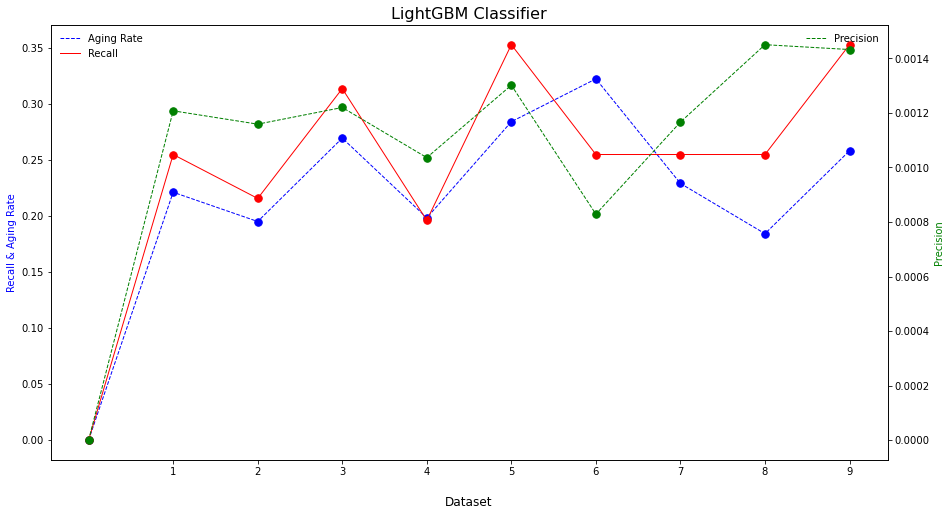

In [6]:
table_setC = runall_LightGBMC(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramC)
line_chart(table_setC, title = 'LightGBM Classifier')

In [7]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,515.934211,156844.0,304.0,0.0,3.0,51.0,48595.0,0.000000,0.000000,0.000062,0.000000,0.000000
dataset 1,1.000000,3067.0,3067.0,13.0,10749.0,38.0,37849.0,0.001208,0.254902,0.221217,1.152270,0.195388
dataset 2,1.000000,4207.0,4207.0,11.0,9480.0,40.0,39118.0,0.001159,0.215686,0.195091,1.105565,0.160597
dataset 3,1.000000,3336.0,3336.0,16.0,13097.0,35.0,35501.0,0.001220,0.313725,0.269543,1.163916,0.242171
dataset 4,1.000000,3038.0,3038.0,10.0,9641.0,41.0,38957.0,0.001036,0.196078,0.198380,0.988397,0.000000
dataset 5,1.006623,3040.0,3020.0,18.0,13807.0,33.0,34791.0,0.001302,0.352941,0.284179,1.241970,0.284949
dataset 6,0.719016,3040.0,4228.0,13.0,15672.0,38.0,32926.0,0.000829,0.254902,0.322412,0.790610,0.000000
dataset 7,1.000000,3040.0,3040.0,13.0,11131.0,38.0,37467.0,0.001167,0.254902,0.229069,1.112771,0.190667
dataset 8,1.000000,3040.0,3040.0,13.0,8949.0,38.0,39649.0,0.001451,0.254902,0.184218,1.383701,0.221422
dataset 9,10.000000,3040.0,304.0,18.0,12545.0,33.0,36053.0,0.001433,0.352941,0.258238,1.366731,0.304062


### Regressor

In [ ]:
pr_dict, table_setR = runall_LightGBMR(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramR, 
                                       thres_target = 'Recall', threshold = 0.7)
line_chart(table_setR, title = 'LightGBM Regressor')

In [ ]:
multiple_curve(4, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(4, 3, pr_dict, table_setR, target = 'Precision')
table_setR

### export

In [8]:
savedate = '20211214'
TPE_multi = True

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'LightGBM'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'LightGBM')